# CCTA Dataset Creation: Ostia HU Attenuation Analysis

---

## 1. Create dataframes collecting the coronary ostia's world coordinates

In [ ]:
%cd ../

%config InlineBackend.figure_format = "retina"

/home/marco/thesis_project/contrast-gan-3D


In [ ]:
from itertools import chain
from pathlib import Path
from pprint import pprint
from typing import Dict, Iterable, Optional, Tuple, Union

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV

from contrast_gan_3D.alias import ScanType
from contrast_gan_3D.config import ROOT_DIR
from contrast_gan_3D.constants import DEFAULT_SEED, VMAX, VMIN
from contrast_gan_3D.data import utils as dset_utils
from contrast_gan_3D.eval import utils as eval_u
from contrast_gan_3D.utils import geometry as geom
from contrast_gan_3D.utils import io_utils, logging_utils
from contrast_gan_3D.utils import visualization as viz

logging_utils.set_project_loggers_level(level="INFO")

rng = np.random.default_rng()

contrast_gan_3D.utils.geometry: INFO -> INFO
contrast_gan_3D.utils.io_utils: INFO -> INFO
contrast_gan_3D.data.utils: INFO -> INFO
contrast_gan_3D.utils.visualization: INFO -> INFO
contrast_gan_3D.eval.CCTAContrastCorrector: INFO -> INFO


Adjust the variables in the following cell to match your setup. Run this code multiple times to process different datasets.

In [ ]:
DATASET_IDS = ["ASOCA_Philips", "MMWHS"]

PREPROC_DATA_DIR = Path("/home/marco/data/preproc")

DATASET_DIRS = [PREPROC_DATA_DIR / i for i in DATASET_IDS]

CENTERLINES_DIRS = [Path("/home/marco/data/auto_centerlines/") / i for i in DATASET_IDS]

OSTIA_DF_SAVENAMES = [dir / "ostia_world.xlsx" for dir in DATASET_DIRS]

pprint(DATASET_DIRS)
pprint(CENTERLINES_DIRS)
pprint(OSTIA_DF_SAVENAMES)

[PosixPath('/home/marco/data/preproc/ASOCA_Philips'),
 PosixPath('/home/marco/data/preproc/MMWHS')]
[PosixPath('/home/marco/data/auto_centerlines/ASOCA_Philips'),
 PosixPath('/home/marco/data/auto_centerlines/MMWHS')]
[PosixPath('/home/marco/data/preproc/ASOCA_Philips/ostia_world.xlsx'),
 PosixPath('/home/marco/data/preproc/MMWHS/ostia_world.xlsx')]


**The following cell might overwrite existing files!**

In [ ]:
if False:
    for centerlines_dir, ostia_df_savename in zip(CENTERLINES_DIRS, OSTIA_DF_SAVENAMES):
        print(f"Centerlines dir: {str(centerlines_dir)!r} Ostias file: {str(ostia_df_savename)!r}")

        ostia_paths = sorted(list(centerlines_dir.glob("*/ostia.xml")))

        ostia_dataframe = dset_utils.create_ostia_dataframe(
            ostia_paths, ostia_sheet_savename=ostia_df_savename
        )
        display(ostia_dataframe.head())

---

## 2. Divide the datapoints in optimal and suboptimal HU contrast values

CCTA scans are divided into *optimal* and *suboptimal* sets based on the contrast medium attenuation values at the 
aortic root. We fit a Mixture of Gaussians model on a 3D patch centered around the aortic root, and identify its 
attenuation value as the component with the highest mean HU value.

This data processing approach is described in 
"[Generative Adversarial Networks for Coronary CT Angiography Acquisition Protocol Correction with Explicit Attenuation Constraints (Van Herten, 2023)](https://openreview.net/pdf?id=MIHF_buWGUQ)"; the following code implementation is adapted from the first author's original codebase.

### 2.1. Create the ostia dataset

Adjust the variables in the following cell to match your setup:

In [ ]:
OSTIAS_COORDS_SAVEPATH = Path("/home/marco/data/ostia_world.xlsx")

pprint(list(zip(DATASET_IDS, OSTIA_DF_SAVENAMES)))
print(OSTIAS_COORDS_SAVEPATH)

[('ASOCA_Philips',
  PosixPath('/home/marco/data/preproc/ASOCA_Philips/ostia_world.xlsx')),
 ('MMWHS', PosixPath('/home/marco/data/preproc/MMWHS/ostia_world.xlsx'))]
/home/marco/data/ostia_world.xlsx


In [ ]:
if False:
    ostia_world_df = pd.concat(
        [
            pd.read_excel(path).assign(dataset=dataset_name)
            for path, dataset_name in zip(OSTIA_DF_SAVENAMES, DATASET_IDS)
        ]
    ).reset_index(drop=True)
    ostia_world_df.to_excel(OSTIAS_COORDS_SAVEPATH, index=False)
    print("Saved ostia dataset")
else:
    ostia_world_df = pd.read_excel(OSTIAS_COORDS_SAVEPATH)
    print("Loaded ostia dataset")

ostia_world_df

Loaded ostia dataset


,ID,x,y,z,dataset
0,ASOCA-000,212.899704,211.107513,-103.750000,ASOCA_Philips
1,ASOCA-000,219.139938,240.228622,-93.125000,ASOCA_Philips
2,ASOCA-001,177.677750,260.138702,-95.750000,ASOCA_Philips
3,ASOCA-001,189.806671,287.226593,-83.250000,ASOCA_Philips
4,ASOCA-002,189.720184,229.135803,-110.125000,ASOCA_Philips
...,...,...,...,...,...
235,ct_train_1018_image,-1.575071,-23.375074,-114.125000,MMWHS
236,ct_train_1019_image,-1.148491,-91.385208,-150.375000,MMWHS
237,ct_train_1019_image,18.871031,-68.436005,-141.625000,MMWHS
238,ct_train_1020_image,37.679688,96.350159,-178.280014,MMWHS


In [ ]:
# **** convert world coordinates dataframe to image ones (convenient for checking manually) ****
# NOTE for MMWHS dataset in ITK-SNAP coordinates are off

OSTIA_DATASET_IMG_COORDS_PATH = OSTIAS_COORDS_SAVEPATH.parent / "ostia_image.xlsx"

if False:
    ostia_img_df = ostia_world_df.copy()
    for dataset_folder in DATASET_DIRS:
        scan_paths = sorted(dataset_folder.glob("*.npy"))
        for path in scan_paths:
            patient_name = io_utils.stem(path)
            scan, meta = dset_utils.load_patient(path.parent / patient_name)
            offset, spacing = meta["offset"], meta["spacing"]

            indexer = [ostia_img_df["ID"] == patient_name, list("xyz")]
            coords = ostia_img_df.loc[*indexer].values

            img_coords = geom.world_to_image_coords(coords, offset, spacing)
            ostia_img_df.loc[*indexer] = img_coords

    ostia_img_df[list("xyz")] = ostia_img_df[list("xyz")].astype(int)

    ostia_img_df.to_excel(OSTIA_DATASET_IMG_COORDS_PATH, index=False)
    print(
        f"Saved ostia image coordinates dataset: {str(OSTIA_DATASET_IMG_COORDS_PATH)!r}"
    )
else:
    ostia_img_df = pd.read_excel(OSTIA_DATASET_IMG_COORDS_PATH)
    print(
        f"Loaded ostia image coordinates dataset: {str(OSTIA_DATASET_IMG_COORDS_PATH)!r}"
    )

ostia_img_df

Loaded ostia image coordinates dataset: '/home/marco/data/ostia_image.xlsx'


,ID,x,y,z,dataset
0,ASOCA-000,231,219,149,ASOCA_Philips
1,ASOCA-000,246,289,166,ASOCA_Philips
2,ASOCA-001,181,265,128,ASOCA_Philips
3,ASOCA-001,211,332,148,ASOCA_Philips
4,ASOCA-002,249,283,174,ASOCA_Philips
...,...,...,...,...,...
235,ct_train_1018_image,192,192,119,MMWHS
236,ct_train_1019_image,226,195,207,MMWHS
237,ct_train_1019_image,267,242,221,MMWHS
238,ct_train_1020_image,234,139,208,MMWHS


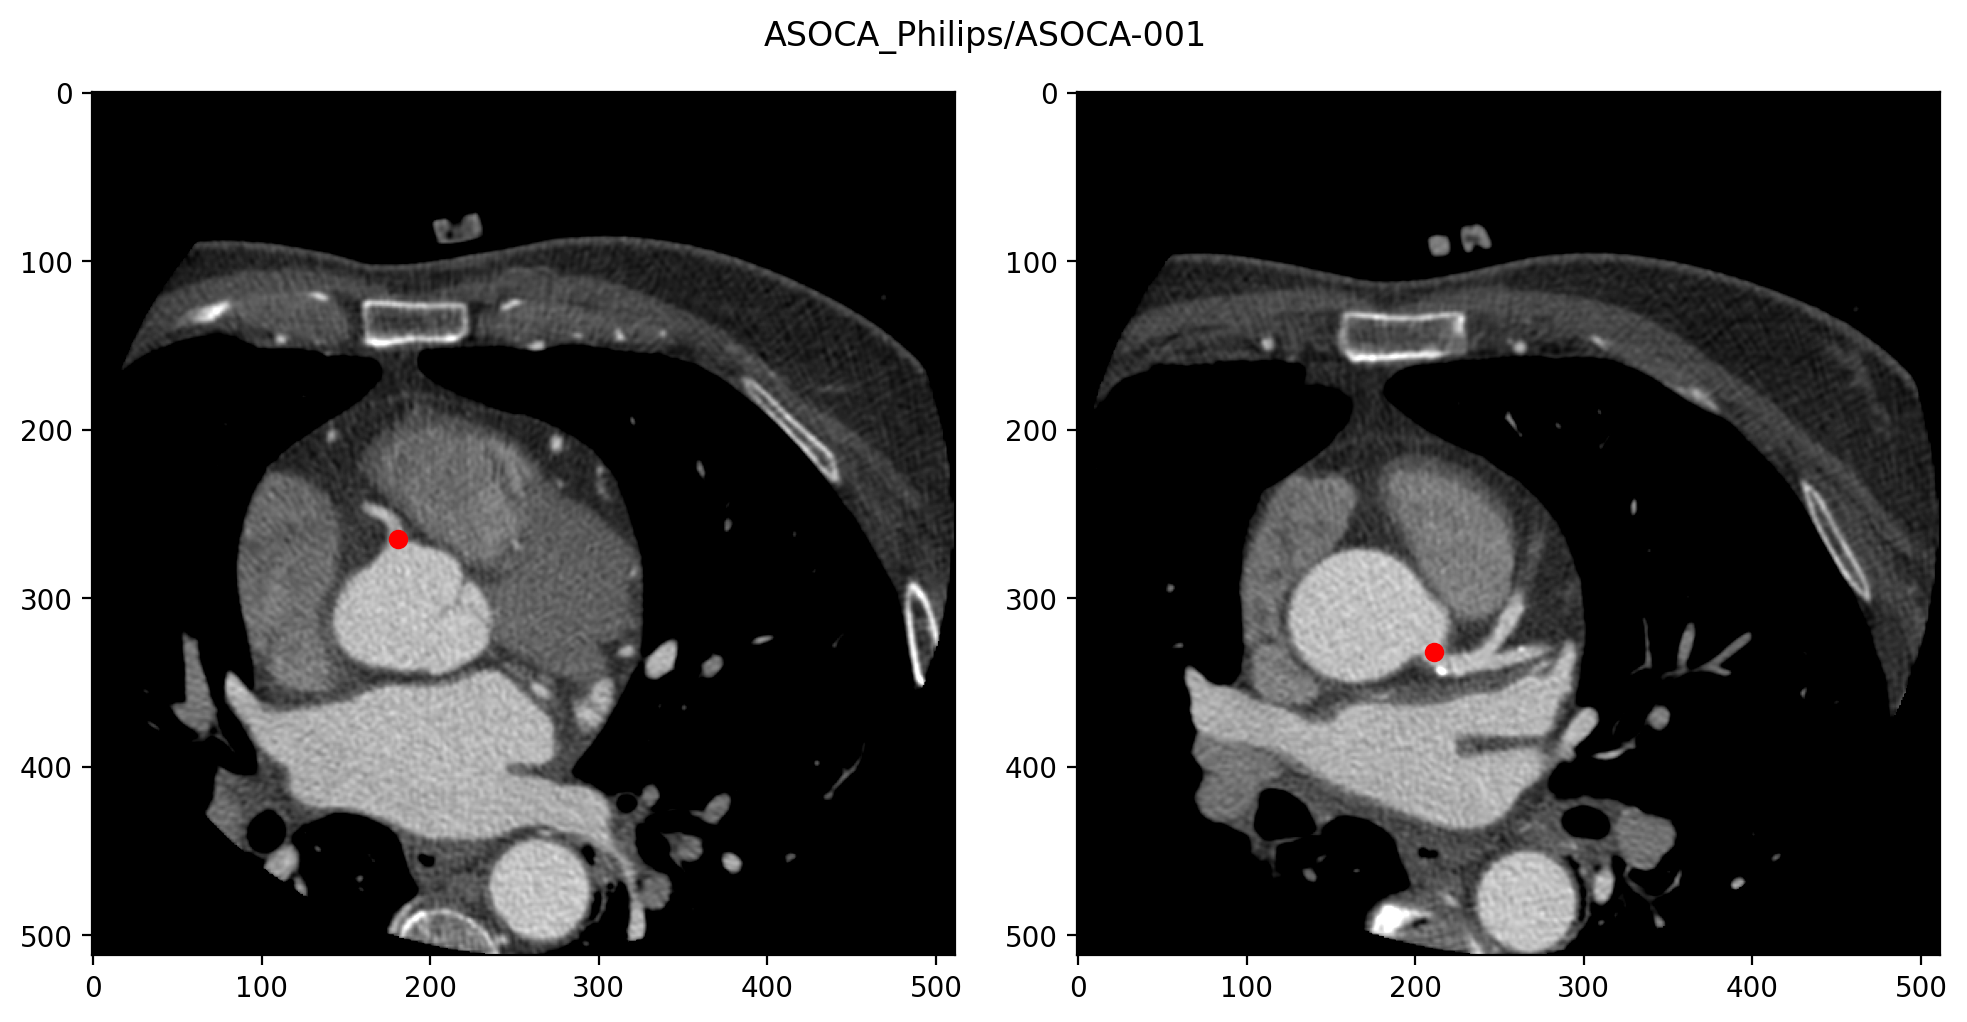

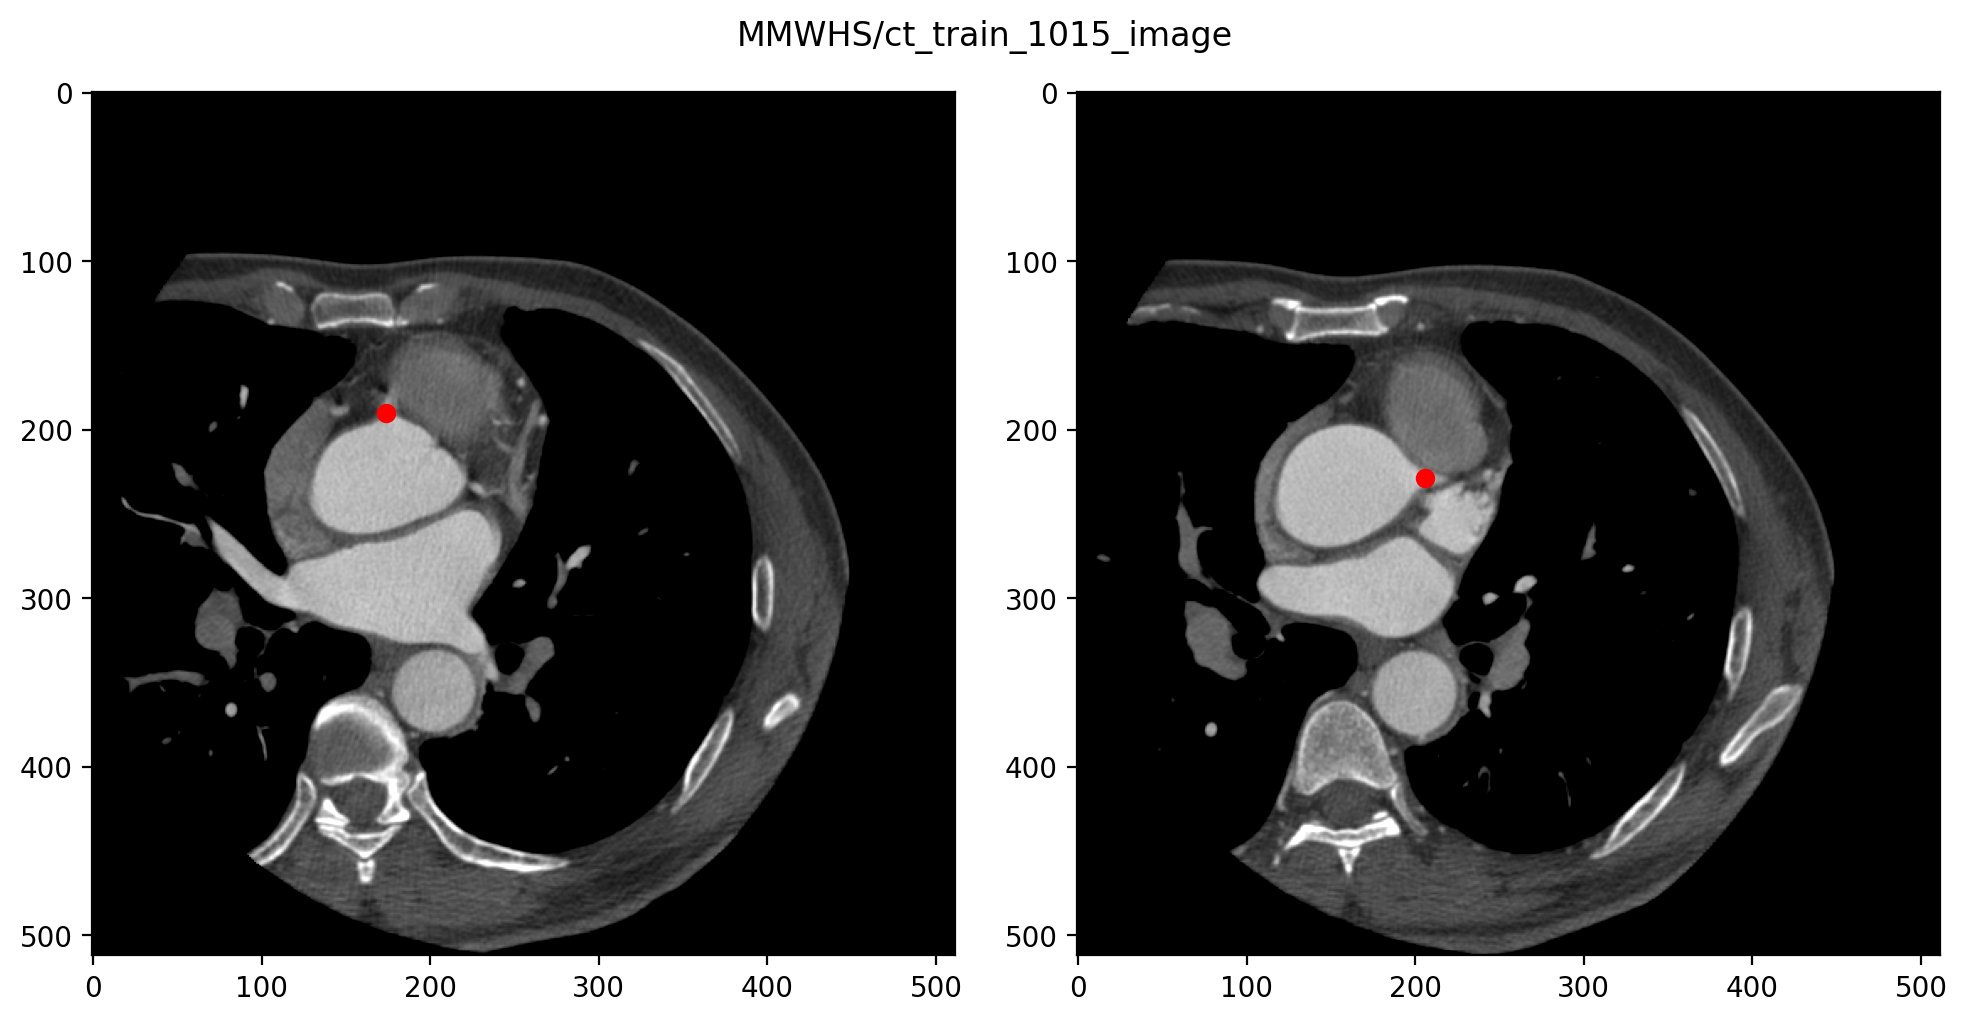

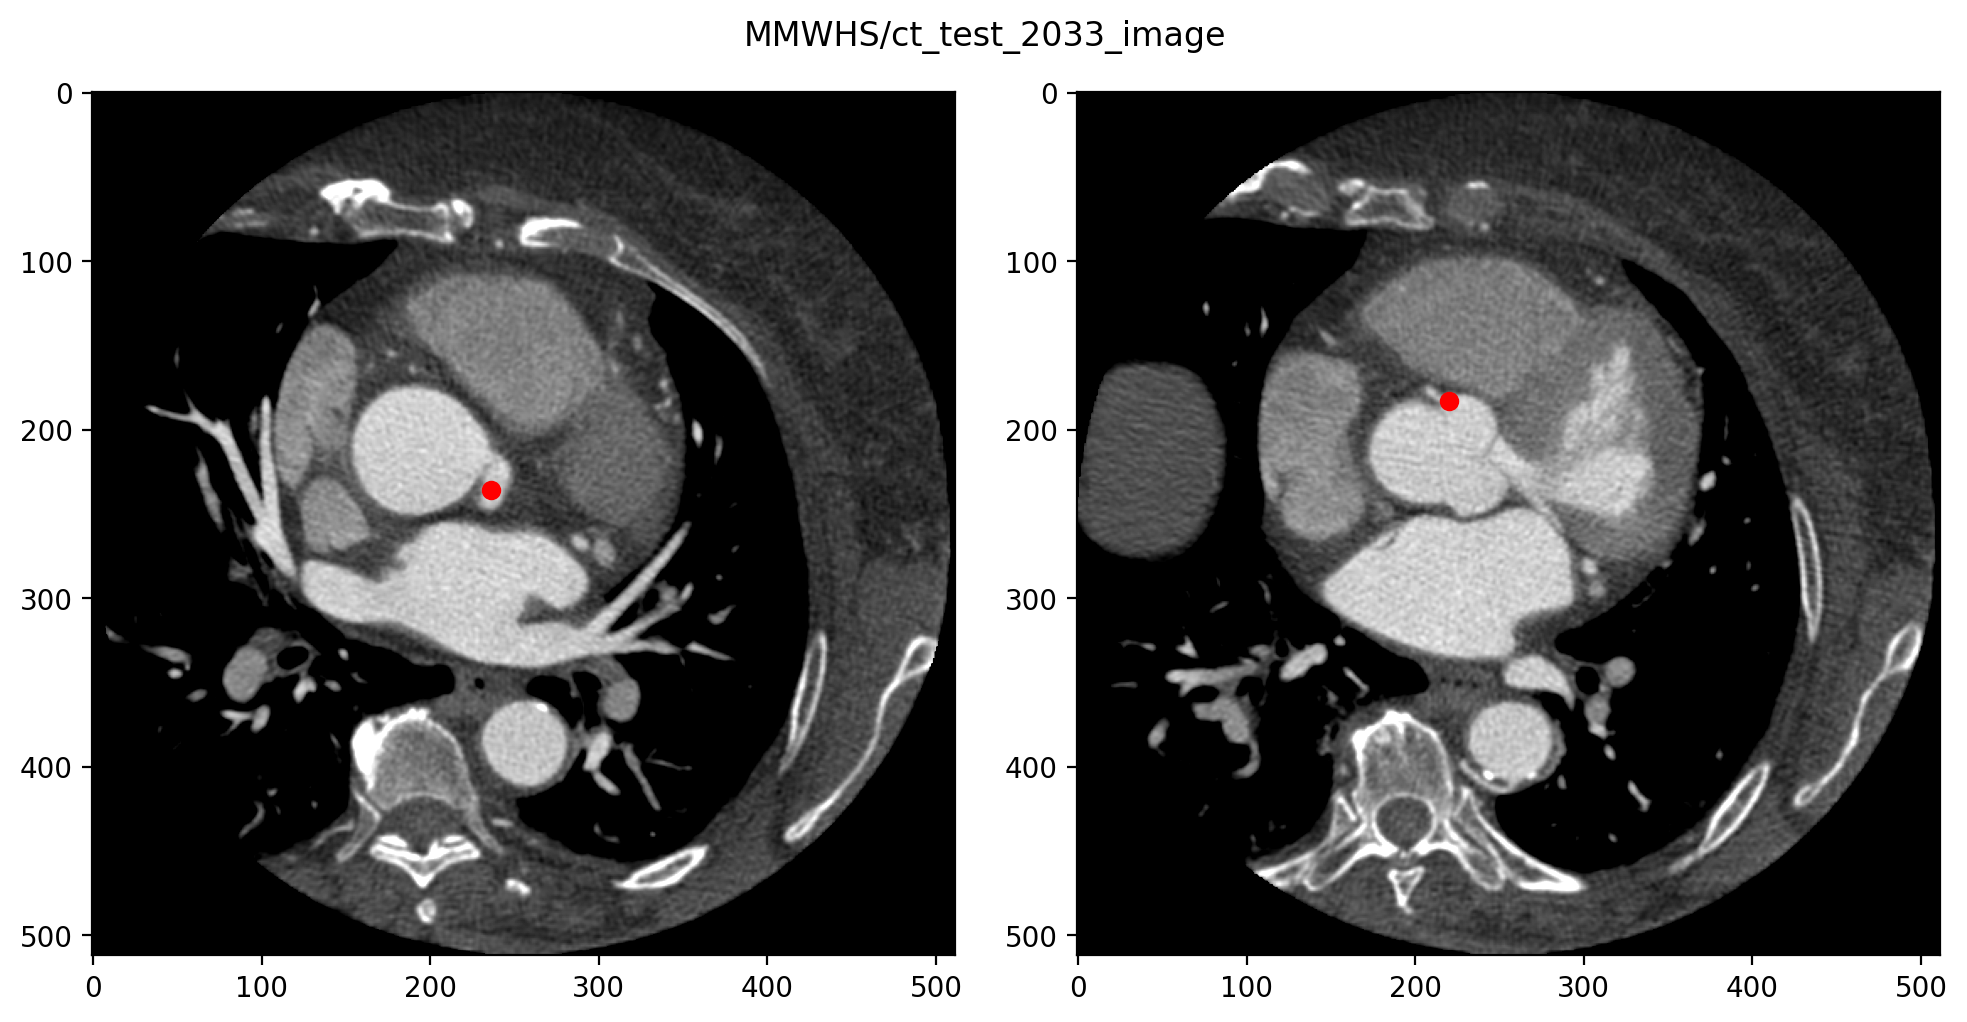

,ID,x,y,z,dataset
2,ASOCA-001,181,265,128,ASOCA_Philips
3,ASOCA-001,211,332,148,ASOCA_Philips
184,ct_test_2033_image,236,236,155,MMWHS
185,ct_test_2033_image,220,183,138,MMWHS
228,ct_train_1015_image,174,190,204,MMWHS
229,ct_train_1015_image,206,229,219,MMWHS


In [ ]:
# check that programmatically accessing ostias from the excel spreadsheet works correctly

RANDOM_SCANS = []

for tag in ["ASOCA", "ct_train", "ct_test"]:
    r = ostia_img_df.loc[ostia_img_df["ID"].str.contains(tag)].sample(1)
    dataset, id_ = r["dataset"].to_list()[0], r["ID"].to_list()[0]
    RANDOM_SCANS.append((id_, dataset))

    scan, _ = dset_utils.load_patient(PREPROC_DATA_DIR / dataset / id_)
    ostia_img = ostia_img_df.loc[
        ostia_img_df["ID"] == id_, list("xyz")
    ].values

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    for i, ax in enumerate(axes.flat):
        ax.imshow(scan[..., ostia_img[i, 2], 0].T, cmap="gray", vmin=VMIN, vmax=VMAX)
        ax.scatter(*ostia_img[i, :-1], c="red")

    fig.suptitle(f"{dataset}/{id_}")
    plt.tight_layout()
    plt.show()
    plt.close()

ostia_img_df.loc[ostia_img_df["ID"].isin([id_ for id_, _ in RANDOM_SCANS])]

---

### 2.2. Extract 3D patches around the ostia and plot some results

These patches are flattened and fitted with a Gaussian Mixture Model to identify the peak corresponding to the contrast
agent's HU intensity. First let's plot some of them to see what they look like.

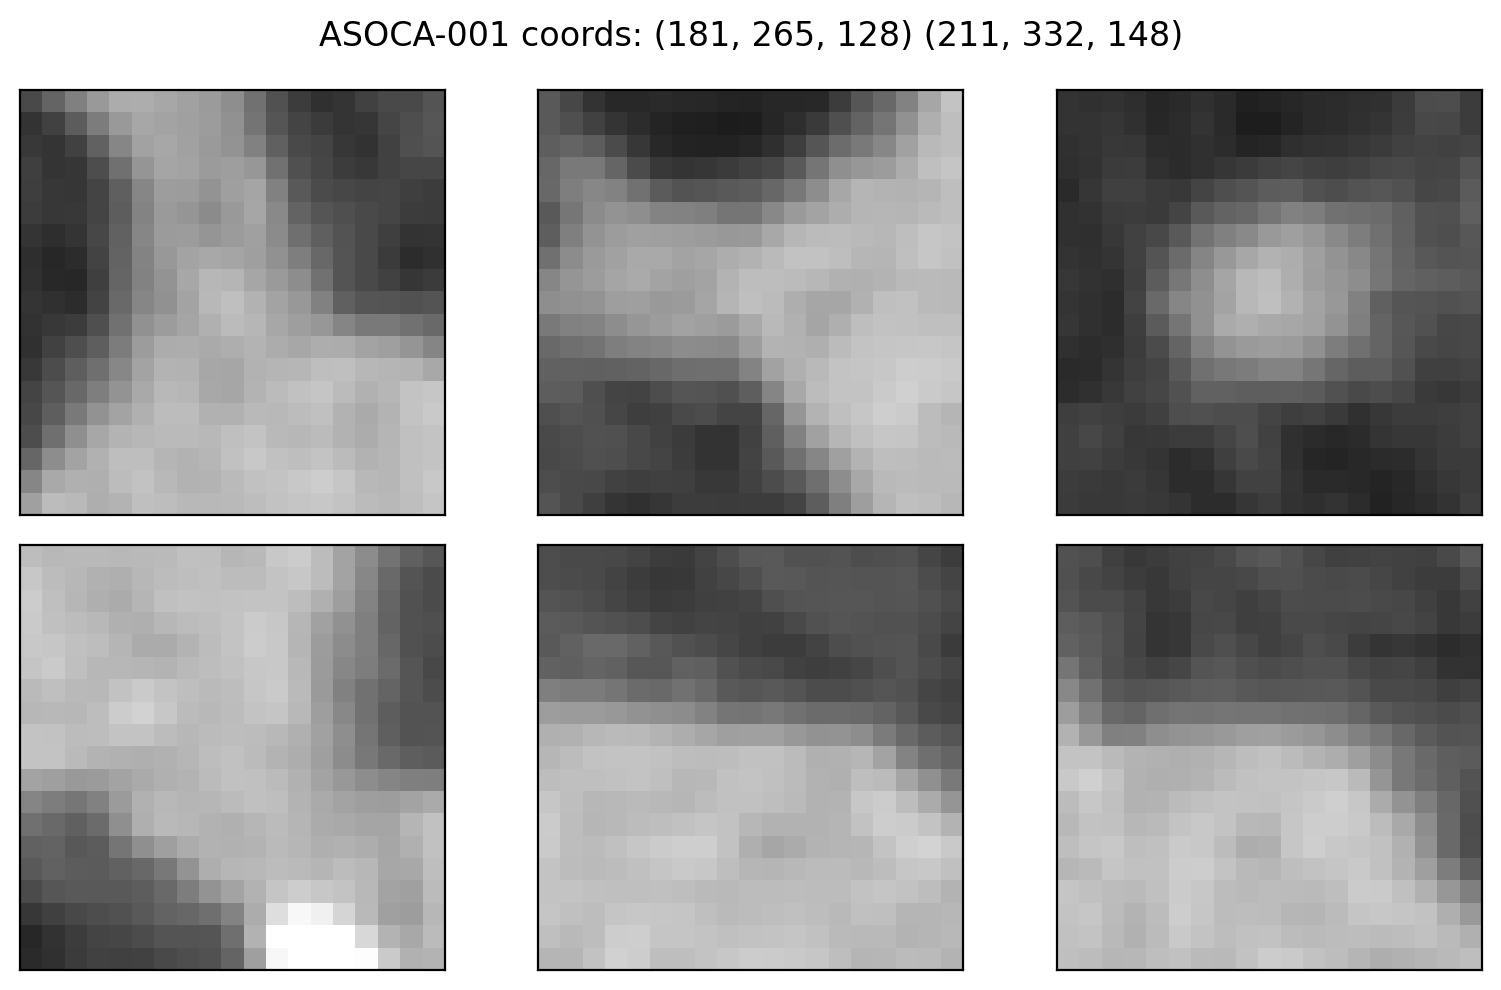

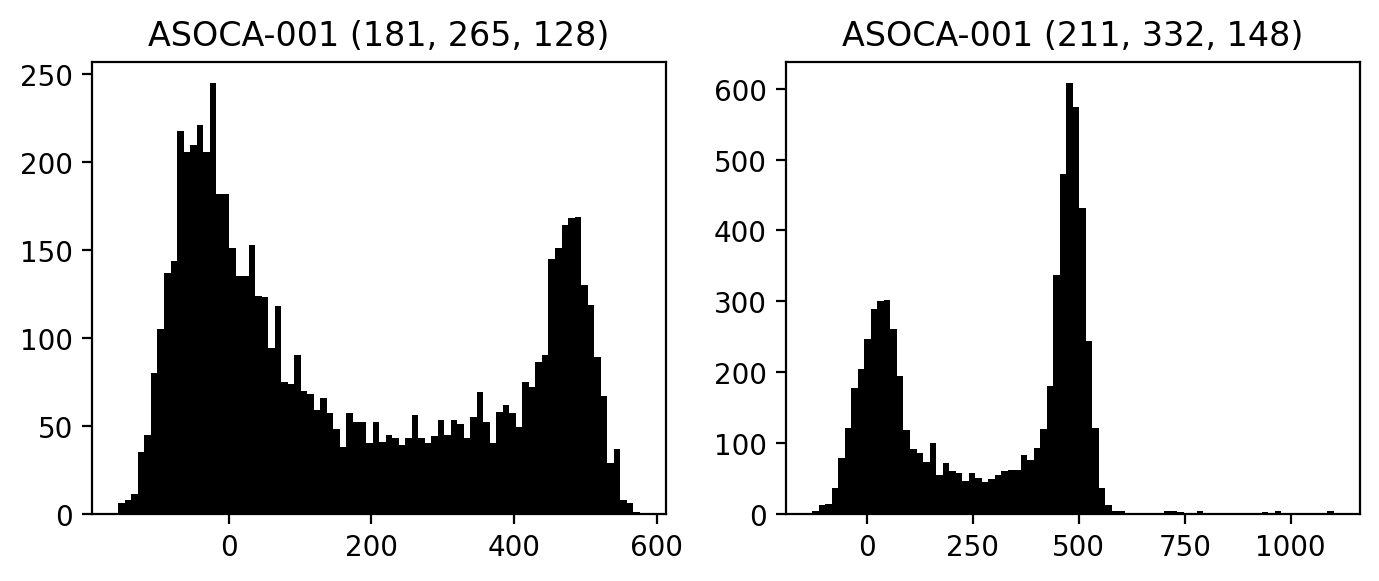

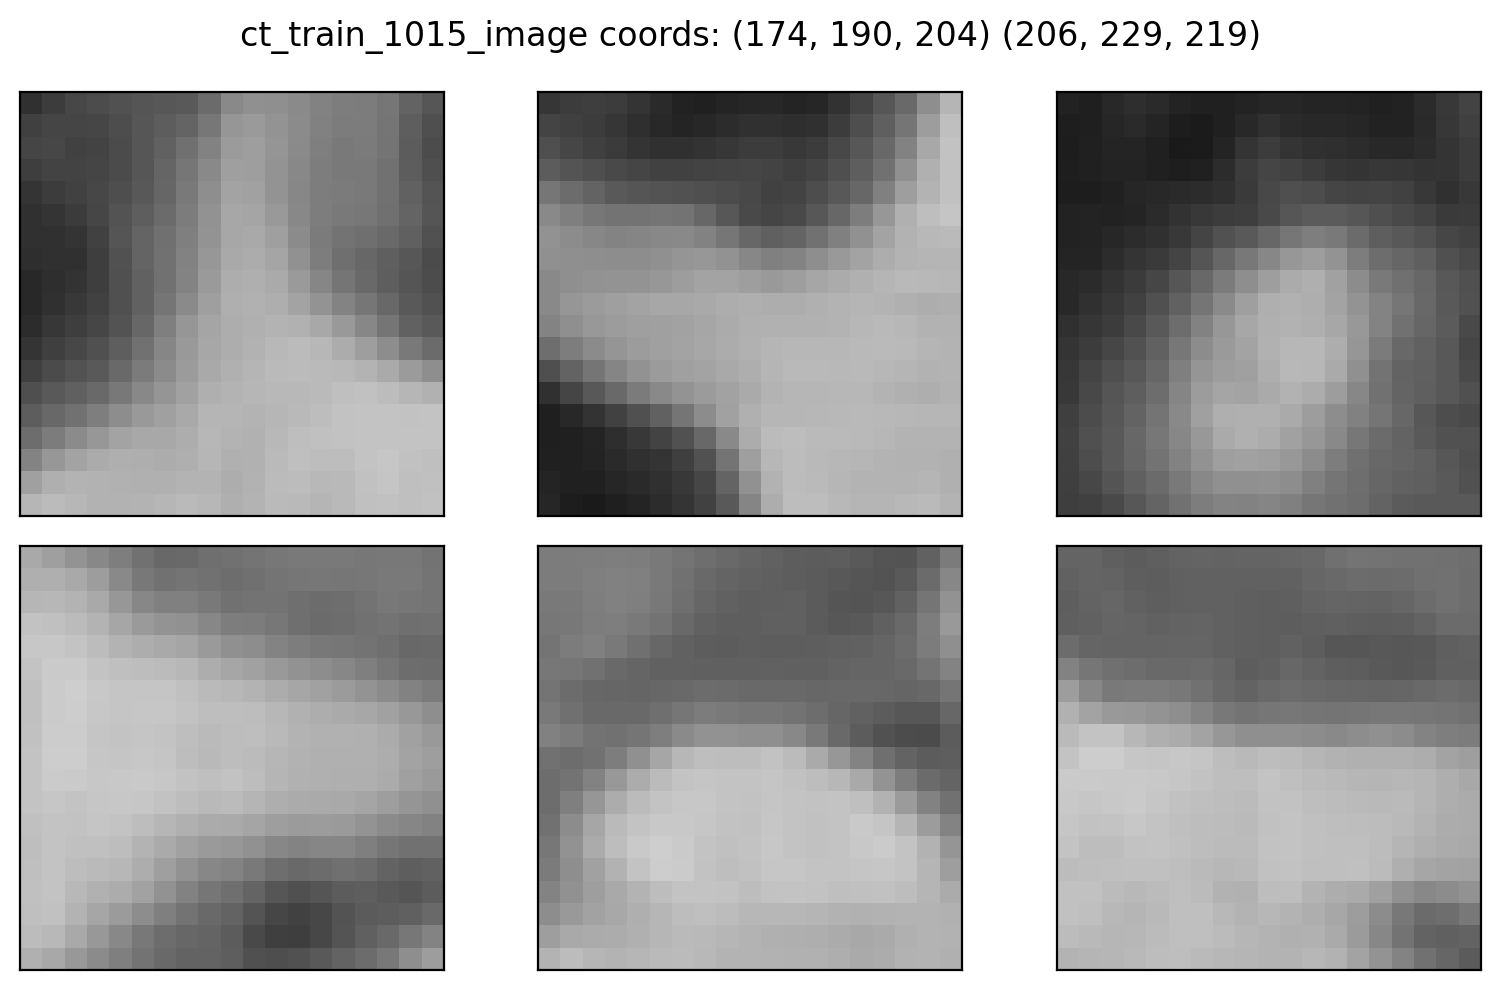

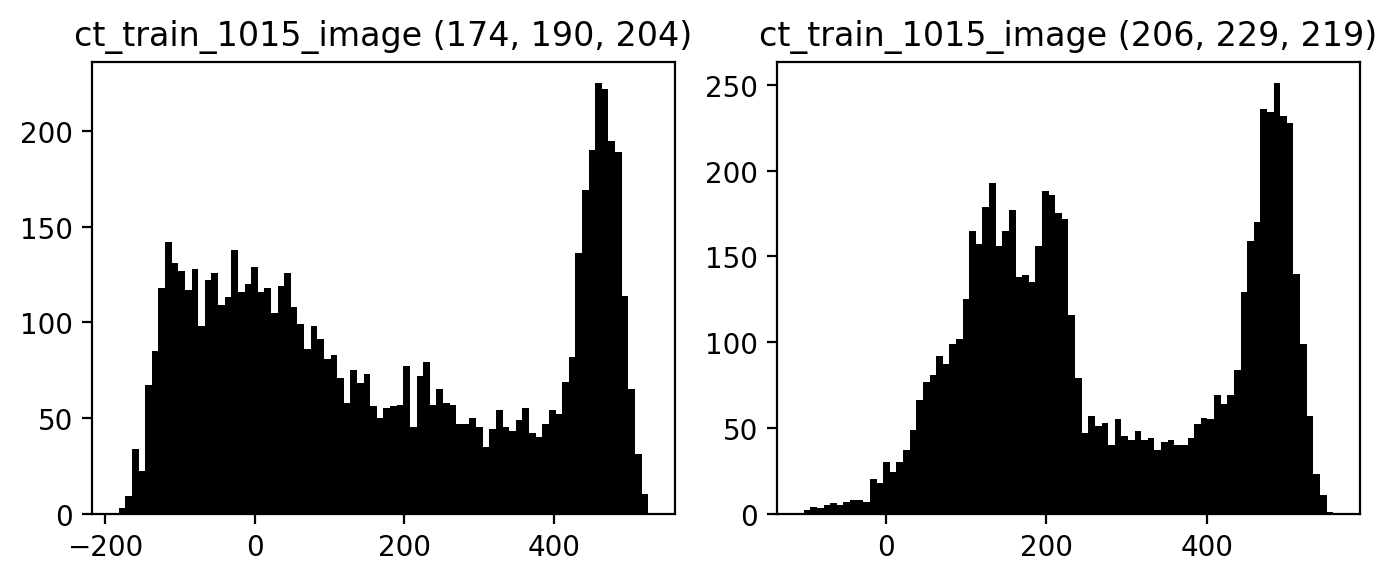

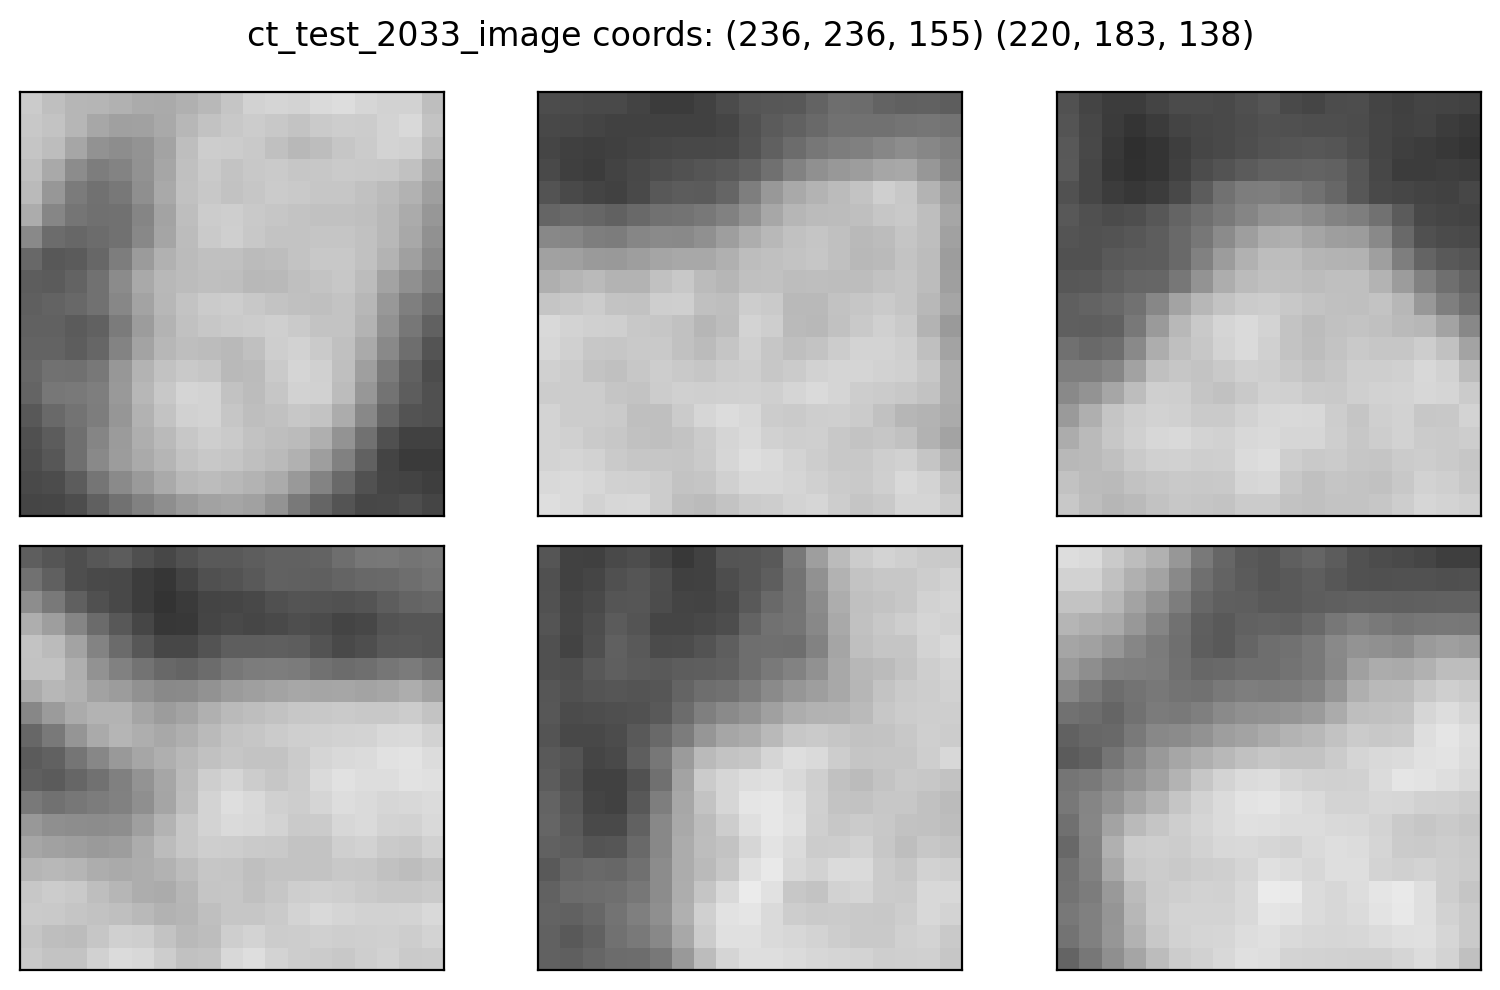

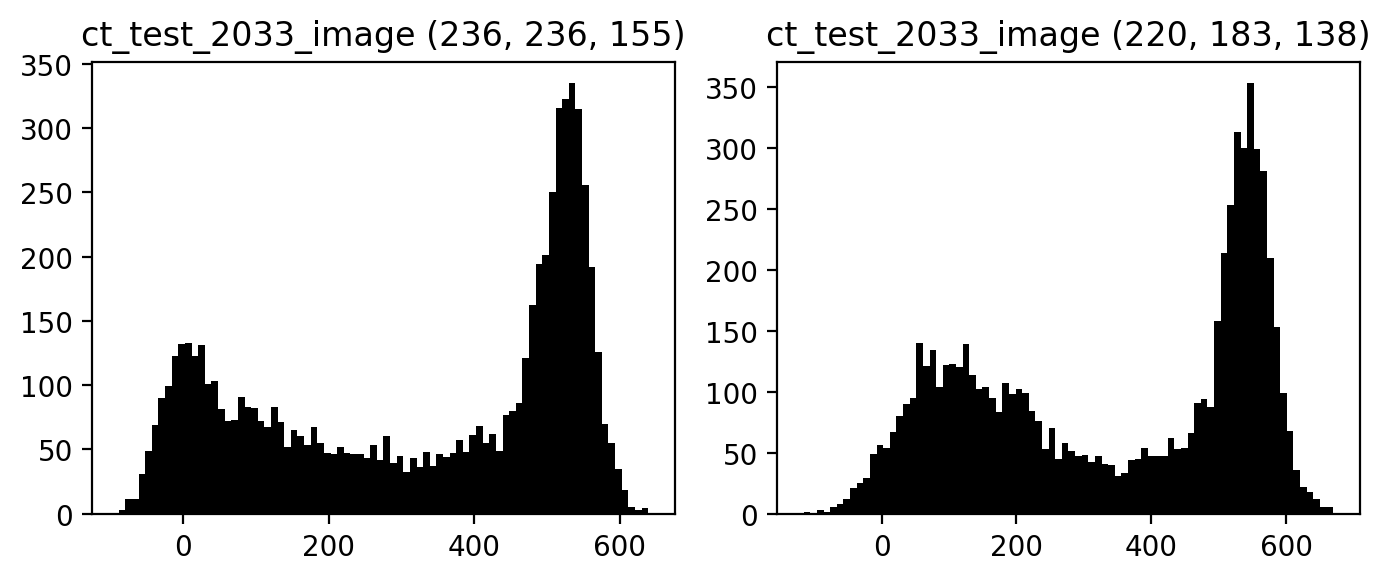

In [ ]:
SAVEDIR = None
# SAVEDIR = Path("/home/marco/contrast-gan-3D/assets/ostia-patches")
if SAVEDIR is not None:
    SAVEDIR.mkdir(parents=True, exist_ok=True)

for id_, dataset in RANDOM_SCANS:
    scan, meta = dset_utils.load_patient(PREPROC_DATA_DIR / dataset / id_)
    ostia_world = ostia_world_df.loc[ostia_world_df["ID"] == id_, list("xyz")].values

    ostia_patches = geom.extract_ostia_patch_3D(
        scan[..., 0], ostia_world, meta["offset"], meta["spacing"]
    )

    ostia_img = geom.world_to_image_coords(
        ostia_world, meta["offset"], meta["spacing"]
    )
    title_coords0, title_coords1 = list(map(tuple, ostia_img))

    fig, axes = plt.subplots(2, 3, figsize=(8, 5))
    for ostium, axes_row in zip(ostia_patches, axes):
        axes = viz.plot_ostium_patch(ostium, axes=axes_row)
    fig.suptitle(
        f"{id_} coords: {title_coords0} {title_coords1}",
    )
    plt.tight_layout()
    if SAVEDIR is None:
        plt.show()
    else:
        plt.savefig(SAVEDIR / f"{id_}_ostia_patches.png")
    plt.close(fig)

    z_middle = ostia_patches.shape[-1] // 2
    axes = viz.plot_image_histogram(
        (ostia_patches[0].ravel(), f"{id_} {title_coords0}"),
        (ostia_patches[1].ravel(), f"{id_} {title_coords1}"),
        tight=True,
        figsize=(7, 3),
    )
    plt.tight_layout()
    if SAVEDIR is None:
        plt.show()
    else:
        plt.savefig(SAVEDIR / f"{id_}_ostia_patches_hist.png")
    plt.close(axes[0, 0].get_figure())

---

### 2.3. Create a dataset of ostia mean HU values and standard deviation

In [ ]:
def GMM_grid_search(
    ostium_patch_1D: np.ndarray,
    max_n_components: int,
    max_iter: int = 1000,
    random_state: Optional[int] = None,
) -> GridSearchCV:
    return GridSearchCV(
        GMM(max_iter=max_iter, random_state=random_state, covariance_type="full"),
        param_grid={"n_components": range(1, max_n_components + 1)},
        scoring=lambda estimator, X: -estimator.bic(X),
    ).fit(ostium_patch_1D)


def pick_GMM_component(gmm: GMM) -> Tuple[Dict[str, float], pd.DataFrame]:
    mu, std = gmm.means_.squeeze(), np.sqrt(gmm.covariances_.squeeze())
    df = pd.DataFrame(
        np.stack([mu, std, gmm.weights_]).T, columns=["mu", "std", "weights"]
    ).sort_values(by="mu", ascending=False)
    return df.loc[df["std"] <= 150, df.columns != "weights"].iloc[0].to_dict(), df


def compute_ostia_HU_value(
    scan_path: Union[Path, str],
    savedir: Optional[Union[Path, str]],
    gmm_max_components: int,
    seed: Optional[int] = None,
    show: bool = True,
) -> Tuple[Dict[str, Union[float, str]], pd.DataFrame, np.ndarray]:
    if savedir is not None:
        savedir = Path(savedir)
        savedir.mkdir(parents=True, exist_ok=True)

    name = io_utils.stem(scan_path)
    scan, meta = dset_utils.load_patient(Path(scan_path).parent / name)
    offset, spacing, ostia_world = meta["offset"], meta["spacing"], meta["ostia_world"]

    # 1. Sample the ostia patches
    ostia_patches = geom.extract_ostia_patch_3D(
        scan[..., 0], ostia_world, offset, spacing
    )
    res = []
    for ostium in ostia_patches.reshape(2, -1, 1):
        # 2. Fit a GMM with hyperparams sweep on the flat patches' intensities
        grid_search = GMM_grid_search(ostium, gmm_max_components, random_state=seed)
        gmm = grid_search.best_estimator_
        print("Optimal # components:", gmm.n_components)
        # 3. Select the Gaussian component with reasonable std and highest mean HU values
        hu_peak, df = pick_GMM_component(gmm)
        res.append(({"ID": name} | hu_peak, df))
        display(df)
        # print(res[-1][0])

    # **** Plotting ****
    ostia_img = geom.world_to_image_coords(ostia_world, offset, spacing)
    title_coords0, title_coords1 = list(map(tuple, ostia_img))

    fig, axes = plt.subplots(2, 5, figsize=(16, 6))
    viz.plot_image_histogram(
        (ostia_patches[0].ravel(), str(title_coords0)),
        (ostia_patches[1].ravel(), str(title_coords1)),
        figsize=(6, 4),
        axes=axes[:, 0],
    )
    for ostium_patch, axes_row, (hu_peak, df) in zip(ostia_patches, axes, res):
        viz.plot_GMM_fitted_ostium_patch(
            ostium_patch,
            *df.values.T[..., None],
            gmm_max_components,
            axes=axes_row[1:],
            title=f"N: {len(df)} mu: {hu_peak['mu']:.2f} std: {hu_peak['std']:.2f}",
        )
    fig.suptitle(f"{name}, columns 1-4: Z middle, 5: full 3D patch")
    plt.tight_layout()
    if savedir is not None:
        plt.savefig(savedir / f"{name}_ostia_HU.png")
    if show:
        plt.show()
    plt.close(fig)

    return *zip(*res), axes

Adjust the variables in the following cell to match your setup:

In [ ]:
HU_DF_FNAME = Path("/home/marco/data/ostia_HU.xlsx")

PLOTS_SAVEDIR = ROOT_DIR / "assets/ostia_HU_GMM/"

SEED = DEFAULT_SEED

GMM_N_MIXTURES = 6

scan_paths = sorted(chain(*[list(d.glob("*.npy")) for d in DATASET_DIRS]))

print(len(scan_paths), scan_paths[0])
print(HU_DF_FNAME)
print(PLOTS_SAVEDIR)
print(GMM_N_MIXTURES)

ostia_world_df

120 /home/marco/data/preproc/ASOCA_Philips/ASOCA-000.npy
/home/marco/data/ostia_HU.xlsx
/home/marco/thesis_project/contrast-gan-3D/assets/ostia_HU_GMM
6


,ID,x,y,z,dataset
0,ASOCA-000,212.899704,211.107513,-103.750000,ASOCA_Philips
1,ASOCA-000,219.139938,240.228622,-93.125000,ASOCA_Philips
2,ASOCA-001,177.677750,260.138702,-95.750000,ASOCA_Philips
3,ASOCA-001,189.806671,287.226593,-83.250000,ASOCA_Philips
4,ASOCA-002,189.720184,229.135803,-110.125000,ASOCA_Philips
...,...,...,...,...,...
235,ct_train_1018_image,-1.575071,-23.375074,-114.125000,MMWHS
236,ct_train_1019_image,-1.148491,-91.385208,-150.375000,MMWHS
237,ct_train_1019_image,18.871031,-68.436005,-141.625000,MMWHS
238,ct_train_1020_image,37.679688,96.350159,-178.280014,MMWHS


Optimal # components: 4


,mu,std,weights
1,471.351614,38.684074,0.243788
3,288.768452,80.542108,0.180354
0,72.786038,58.500962,0.213626
2,-40.829904,41.047983,0.362232


Optimal # components: 6


,mu,std,weights
4,724.055973,199.173533,0.006082
5,485.709966,29.052631,0.404138
1,407.876855,53.541911,0.109469
3,232.120074,68.397600,0.098061
2,70.889993,46.968198,0.159956
0,5.036204,41.808749,0.222294


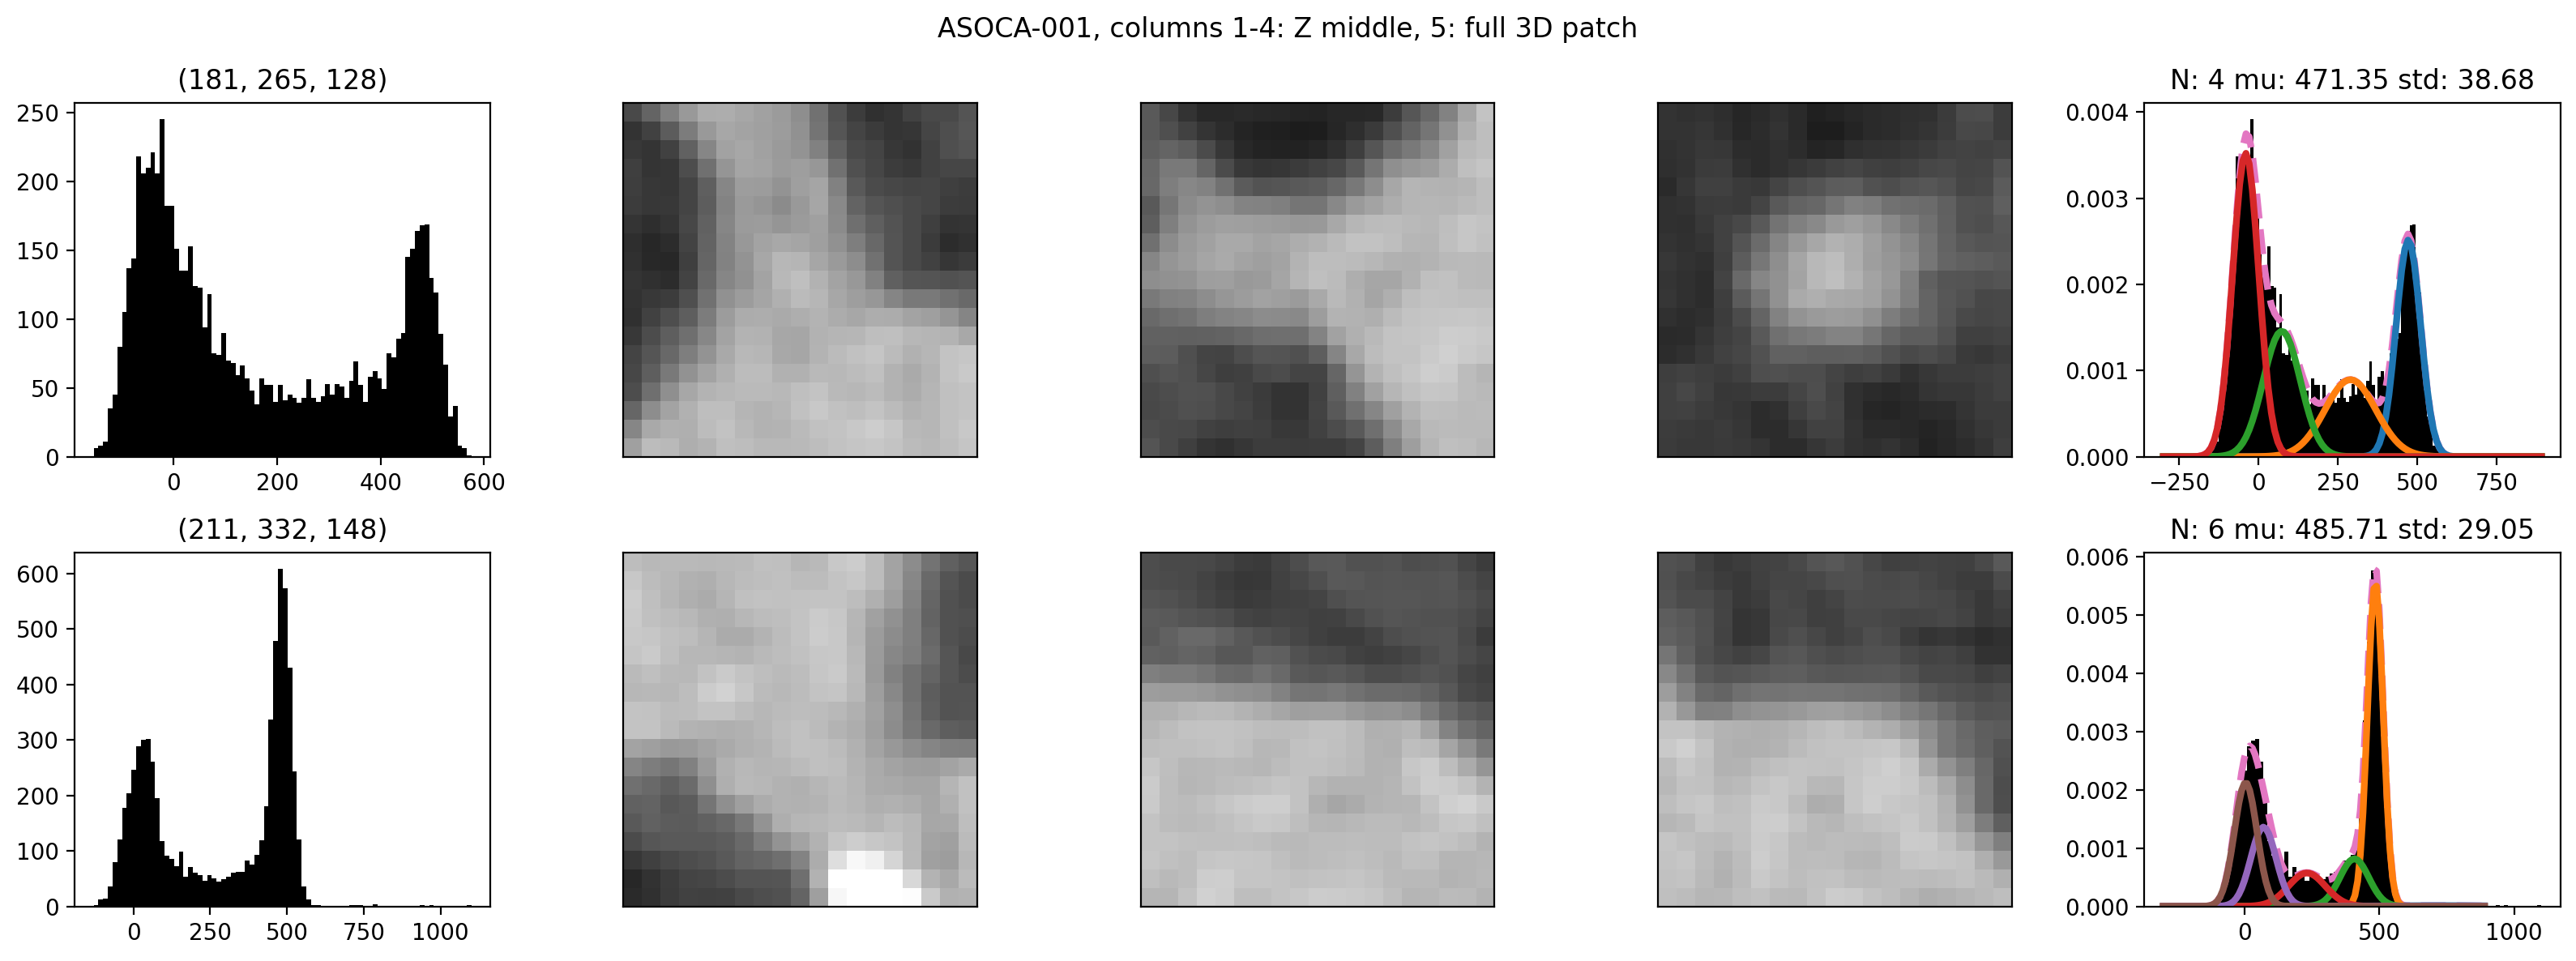

Optimal # components: 4


,mu,std,weights
2,460.251654,26.608568,0.248646
1,267.344884,87.791869,0.229906
3,56.929779,60.660597,0.257412
0,-74.710287,46.779538,0.264036


Optimal # components: 2


,mu,std,weights
1,471.246344,37.010566,0.355552
0,168.654195,89.492090,0.644448


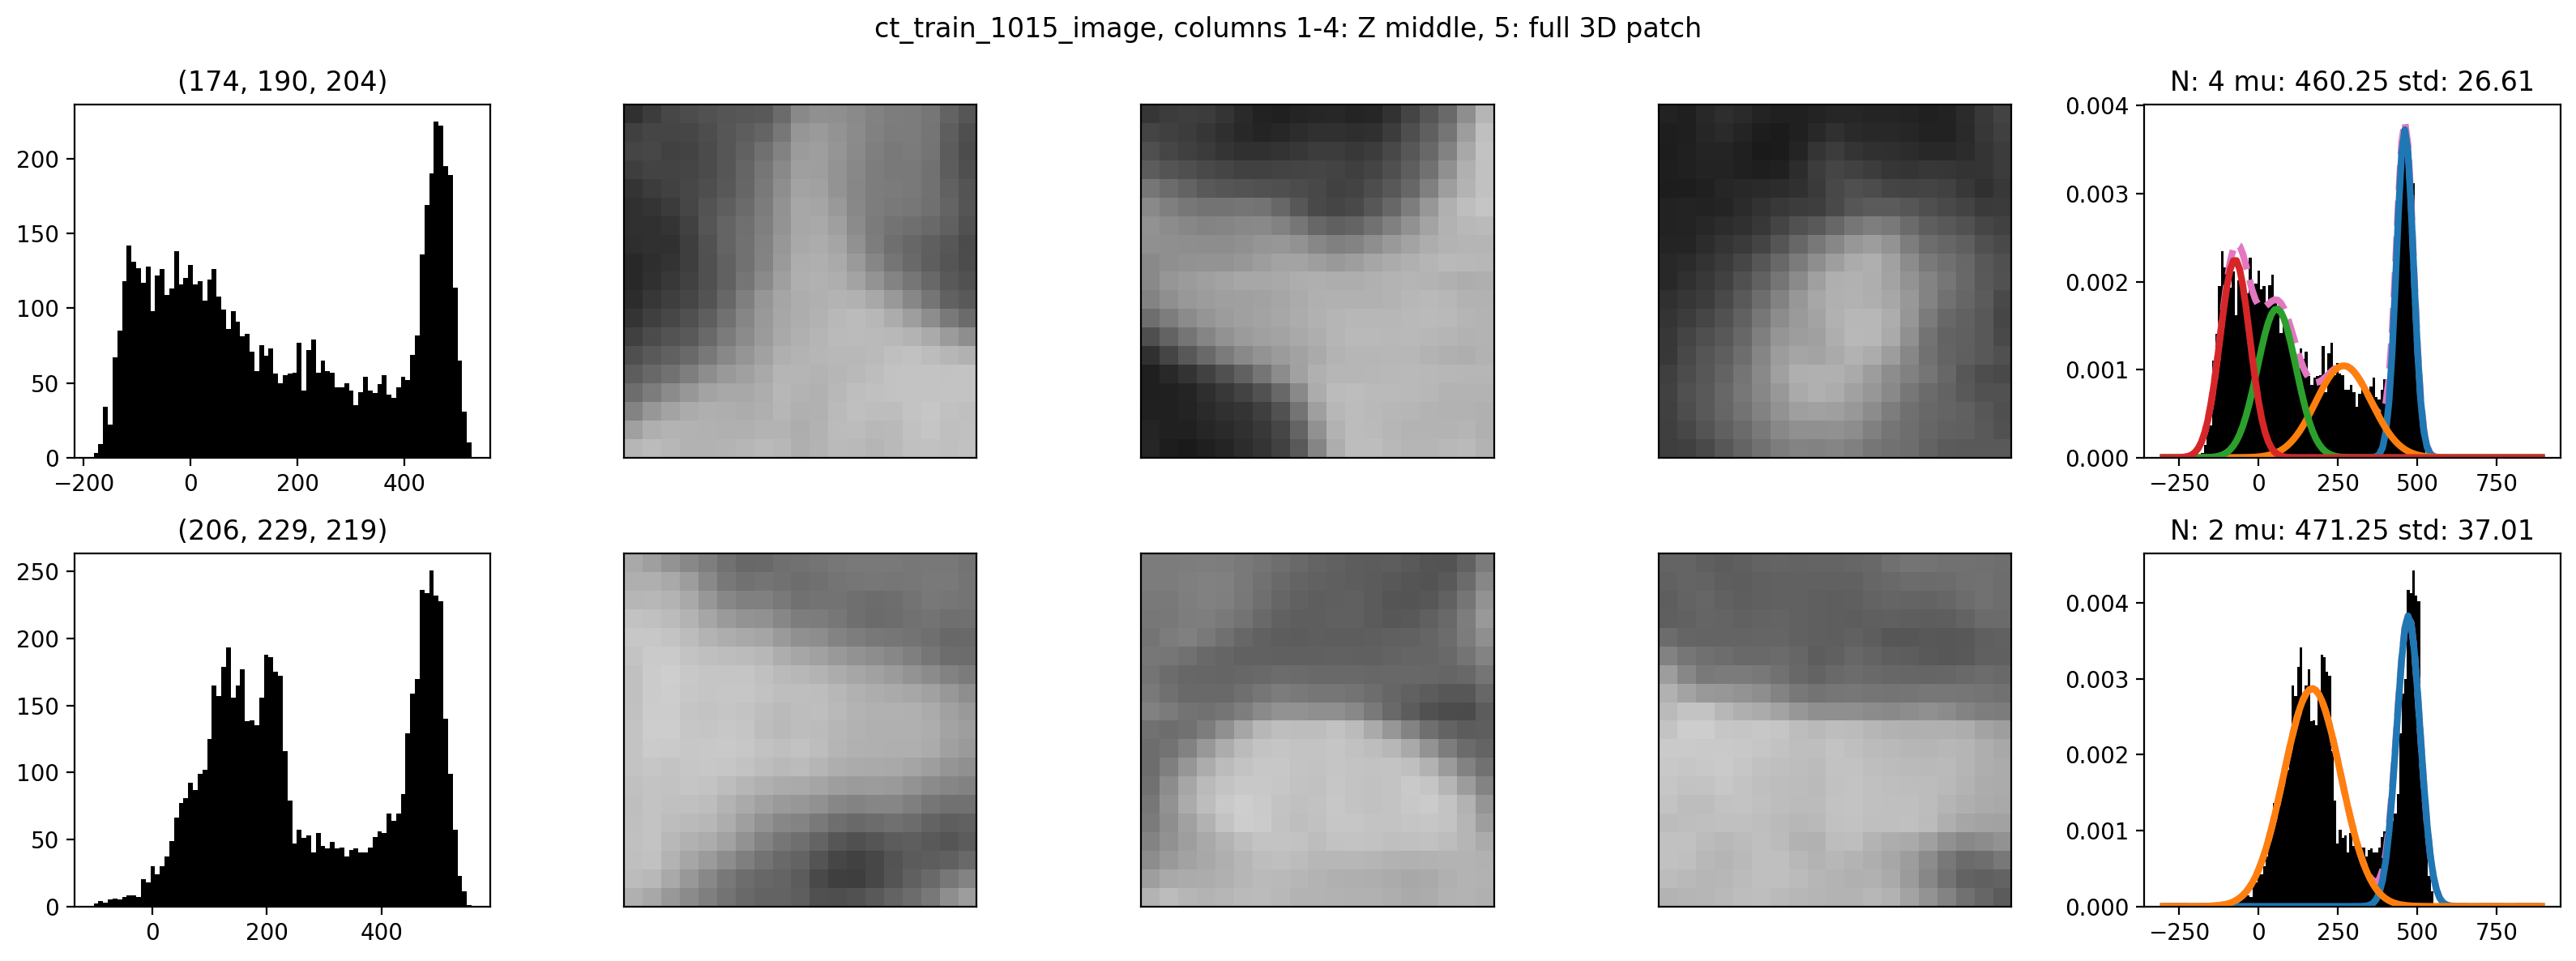

Optimal # components: 5


,mu,std,weights
4,529.727243,31.147436,0.399387
1,438.924507,49.430508,0.136189
2,282.394322,58.634646,0.114795
3,129.738281,50.100782,0.149762
0,9.329850,37.176113,0.199868


Optimal # components: 3


,mu,std,weights
0,539.741802,39.812299,0.453914
2,289.657132,112.516215,0.238337
1,94.168391,68.763365,0.307750


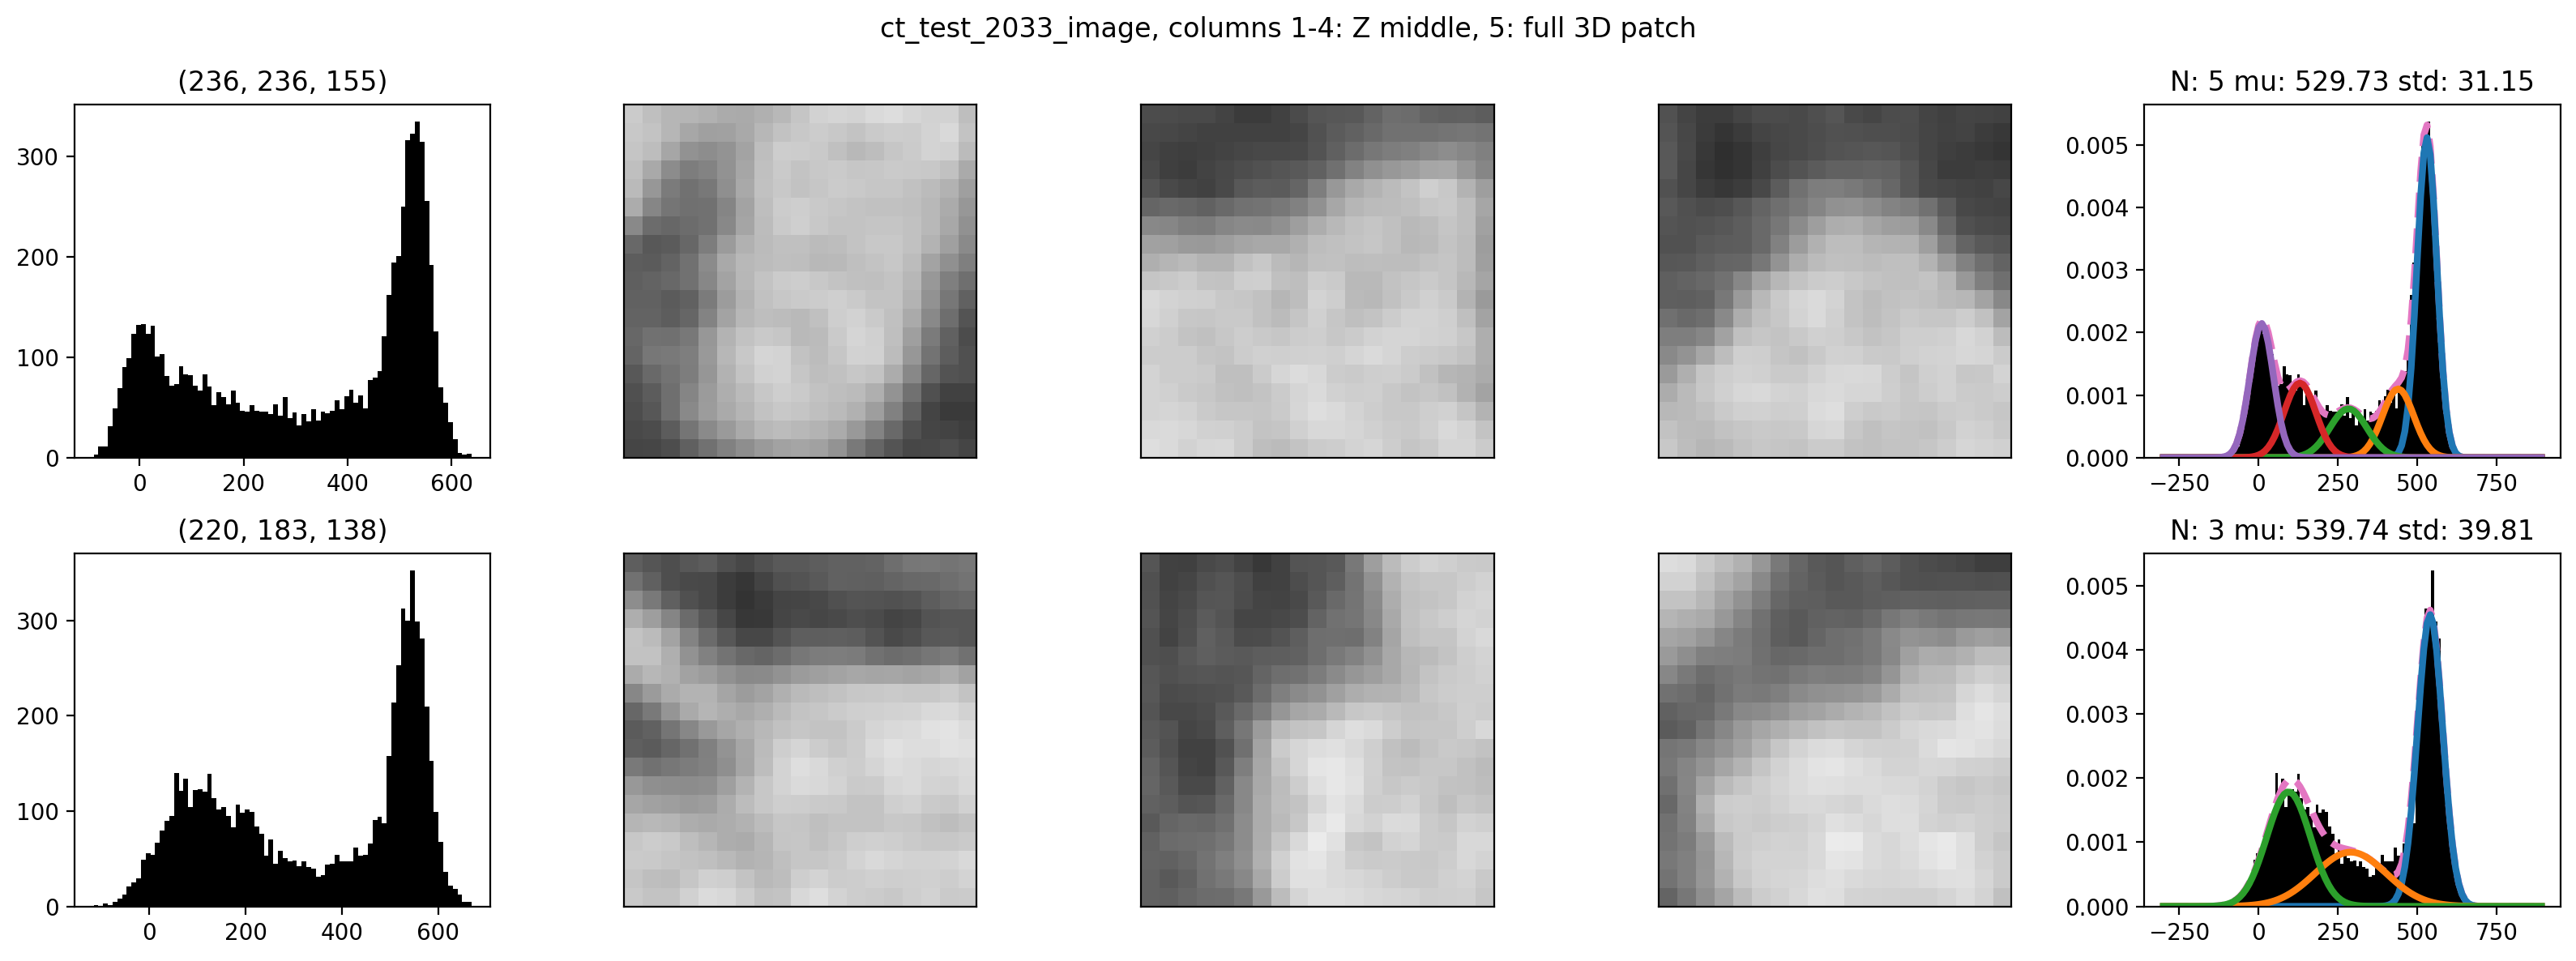

In [ ]:
# check that things make sense

for id_, dataset in RANDOM_SCANS:
    scan_path = PREPROC_DATA_DIR / dataset / id_
    a = compute_ostia_HU_value(scan_path, None, GMM_N_MIXTURES)

**The following cell might overwrite existing files!**

In [ ]:
# %%time

if False:
    ostia_HU_df = []
    for s in scan_paths:
        print(s)
        hu_peaks, *_ = compute_ostia_HU_value(
            s,
            PLOTS_SAVEDIR,
            GMM_N_MIXTURES,
            seed=SEED,
            show=False,
        )
        print("---")
        ostia_HU_df += hu_peaks

    ostia_HU_df = pd.DataFrame(ostia_HU_df)
    ostia_HU_df.to_excel(HU_DF_FNAME, index=False)
    print(f"Saved HU dataframe to '{HU_DF_FNAME}'")
    ostia_HU_df

/home/marco/data/preproc/ASOCA_Philips/ASOCA-000.npy
Optimal # components: 4


,mu,std,weights
1,411.801545,38.914087,0.396761
2,257.827960,60.096667,0.135444
3,87.639241,47.908817,0.228660
0,-26.933378,44.334276,0.239135


Optimal # components: 3


,mu,std,weights
0,417.637377,39.911285,0.529622
2,221.130198,76.924516,0.166365
1,35.644469,53.143598,0.304013


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-001.npy
Optimal # components: 4


,mu,std,weights
1,471.351123,38.684994,0.243777
3,288.678682,80.612866,0.180511
0,72.742994,58.442529,0.213461
2,-40.834377,41.044009,0.362251


Optimal # components: 6


,mu,std,weights
0,482.516019,29.968211,0.423577
5,360.773863,57.649968,0.069880
4,360.208289,177.713542,0.081344
2,164.388986,55.924603,0.086590
1,50.873695,31.875733,0.172775
3,-8.142836,37.834836,0.165835


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-002.npy
Optimal # components: 4


,mu,std,weights
0,544.765628,29.733012,0.444223
2,374.312213,83.879078,0.125926
1,148.538194,64.276115,0.159577
3,-3.905570,45.617480,0.270273


Optimal # components: 5


,mu,std,weights
0,530.456570,33.325141,0.224585
3,392.733504,64.826559,0.116333
4,202.271691,62.341646,0.121760
1,65.172703,46.530261,0.207787
2,-40.985220,36.299183,0.329535


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-003.npy
Optimal # components: 3


,mu,std,weights
0,507.543314,38.234905,0.458110
2,280.423495,106.879530,0.196945
1,37.078670,72.003071,0.344946


Optimal # components: 5


,mu,std,weights
3,509.628208,38.599440,0.169778
1,355.873163,65.119698,0.110928
4,171.967047,60.479190,0.130990
2,38.728662,42.144691,0.251887
0,-51.277024,37.033506,0.336416


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-004.npy
Optimal # components: 4


,mu,std,weights
1,565.964696,32.100598,0.173467
3,342.454072,105.139258,0.162721
2,101.858182,61.732685,0.279558
0,-34.080243,47.988761,0.384254


Optimal # components: 3


,mu,std,weights
0,538.986590,37.067749,0.414827
2,318.518257,108.730127,0.198338
1,47.827502,62.771668,0.386836


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-005.npy
Optimal # components: 4


,mu,std,weights
1,467.497498,49.098265,0.310105
2,282.898367,66.774820,0.148729
3,88.787083,53.554955,0.273039
0,-44.681938,48.162207,0.268127


Optimal # components: 3


,mu,std,weights
0,499.879015,35.677081,0.320447
2,275.921489,105.752693,0.224184
1,34.171419,60.194512,0.455368


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-006.npy
Optimal # components: 4


,mu,std,weights
1,612.403967,33.656340,0.256164
3,387.325441,121.799304,0.183742
2,85.780546,76.063209,0.199850
0,-51.477751,35.118280,0.360244


Optimal # components: 3


,mu,std,weights
0,604.620757,31.469407,0.327396
2,355.310411,130.691617,0.296842
1,67.494317,71.939126,0.375761


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-007.npy
Optimal # components: 4


,mu,std,weights
0,433.869466,35.707495,0.489772
3,294.722655,61.560134,0.107351
1,98.513877,55.012546,0.194772
2,-40.943741,49.178989,0.208104


Optimal # components: 3


,mu,std,weights
1,331.959976,48.271397,0.330752
0,108.595770,69.131884,0.251979
2,-23.921644,49.906120,0.417268


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-008.npy
Optimal # components: 4


,mu,std,weights
0,461.915998,33.236958,0.511383
2,333.244197,59.997718,0.102291
3,164.363419,51.930346,0.113856
1,46.820129,34.191614,0.272470


Optimal # components: 5


,mu,std,weights
1,460.968413,33.036155,0.312643
3,331.659458,55.119818,0.105097
2,160.541838,50.992410,0.127037
0,43.815479,40.862343,0.198968
4,-53.923566,34.177623,0.256256


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-009.npy
Optimal # components: 3


,mu,std,weights
0,431.659979,33.071831,0.353366
2,216.922979,99.994166,0.200494
1,6.464918,52.635038,0.446141


Optimal # components: 4


,mu,std,weights
3,434.282341,41.880810,0.312392
1,268.052296,70.306969,0.157067
2,57.018628,55.056238,0.243593
0,-61.552621,42.698046,0.286948


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-010.npy
Optimal # components: 5


,mu,std,weights
2,521.358295,24.607433,0.243875
3,398.670998,68.633500,0.137150
0,190.756551,66.500725,0.111898
1,31.439696,53.877127,0.235341
4,-80.191284,29.534212,0.271736


Optimal # components: 3


,mu,std,weights
0,523.501385,21.935283,0.356126
1,330.890631,108.598118,0.179376
2,56.346192,62.392695,0.464498


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-011.npy
Optimal # components: 4


,mu,std,weights
3,583.228490,41.632062,0.216534
1,374.371983,89.645171,0.204118
2,139.983839,52.716253,0.386144
0,-17.628266,53.769396,0.193203


Optimal # components: 5


,mu,std,weights
0,548.395856,27.786608,0.487025
2,453.747230,43.681681,0.148829
4,303.408244,55.724160,0.116189
3,162.379609,52.903072,0.140318
1,26.403307,58.444946,0.107640


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-012.npy
Optimal # components: 5


,mu,std,weights
1,615.833548,47.851438,0.211232
3,426.432439,76.077011,0.093565
0,209.439053,65.343073,0.094640
4,31.861615,47.716562,0.222496
2,-61.576385,34.086024,0.378067


Optimal # components: 5


,mu,std,weights
0,676.465494,21.337146,0.410817
2,537.712001,83.943994,0.145175
4,268.117405,82.468004,0.107981
1,85.638475,43.943985,0.205703
3,-47.904800,36.021873,0.130324


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-013.npy
Optimal # components: 4


,mu,std,weights
1,550.157273,54.814328,0.225004
2,329.095936,84.652717,0.148440
3,103.967494,60.782455,0.233075
0,-20.141337,47.510050,0.393481


Optimal # components: 3


,mu,std,weights
0,584.202409,37.658119,0.516430
2,339.798188,106.862423,0.228428
1,73.855820,80.219543,0.255142


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-014.npy
Optimal # components: 4


,mu,std,weights
0,494.713668,27.925255,0.317059
3,339.244685,80.509267,0.157043
1,126.237813,60.523806,0.223275
2,9.199813,53.079382,0.302623


Optimal # components: 5


,mu,std,weights
0,511.021613,36.904721,0.185698
4,351.854091,70.454654,0.116940
2,156.536065,61.570177,0.121114
1,19.074094,45.790129,0.214716
3,-80.794376,25.441799,0.361532


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-015.npy
Optimal # components: 3


,mu,std,weights
0,549.299168,31.638944,0.468108
2,322.904837,117.540926,0.229773
1,50.232958,59.302071,0.302119


Optimal # components: 2


,mu,std,weights
1,450.375332,86.263240,0.313144
0,109.969111,84.160356,0.686856


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-016.npy
Optimal # components: 4


,mu,std,weights
1,531.012765,47.060527,0.232332
3,315.935575,84.793135,0.130318
0,105.215420,53.433833,0.316584
2,-21.365304,45.157608,0.320766


Optimal # components: 4


,mu,std,weights
0,574.329456,40.853517,0.406556
2,418.684371,68.343925,0.121071
1,198.207039,66.739019,0.136598
3,29.699447,52.522707,0.335775


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-017.npy
Optimal # components: 4


,mu,std,weights
0,638.796199,36.113522,0.358174
2,400.979409,123.117260,0.165780
1,130.960752,60.265358,0.270768
3,-12.343061,40.023694,0.205277


Optimal # components: 4


,mu,std,weights
1,650.182540,37.022979,0.269308
2,426.367573,112.483373,0.123792
3,118.804183,67.738806,0.186201
0,-3.062398,35.419578,0.420699


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-018.npy
Optimal # components: 4


,mu,std,weights
0,354.409929,28.734544,0.428364
3,218.895981,54.067424,0.118154
2,62.999421,44.464617,0.238499
1,-56.943314,37.022250,0.214983


Optimal # components: 4


,mu,std,weights
1,356.610849,31.402355,0.339564
3,222.696989,52.954562,0.124685
2,77.183730,43.221447,0.256002
0,-42.499334,41.015993,0.279749


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-019.npy
Optimal # components: 4


,mu,std,weights
1,477.880021,58.956662,0.191638
2,280.904403,79.684410,0.126947
0,72.968146,61.164349,0.170012
3,-53.009305,37.684932,0.511404


Optimal # components: 3


,mu,std,weights
0,493.164363,44.935987,0.391684
2,233.826117,121.864537,0.237782
1,-52.451584,62.163225,0.370534


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-020.npy
Optimal # components: 3


,mu,std,weights
0,321.612526,53.507392,0.527729
2,126.203690,64.307692,0.144221
1,-24.792413,48.596540,0.328050


Optimal # components: 3


,mu,std,weights
1,244.343353,55.331269,0.245831
0,91.053507,39.029918,0.461352
2,-28.309038,40.627436,0.292816


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-021.npy
Optimal # components: 4


,mu,std,weights
0,448.400795,42.165122,0.429774
2,291.401721,68.148834,0.157283
1,100.696302,56.329340,0.221133
3,-25.090385,49.590400,0.191810


Optimal # components: 4


,mu,std,weights
2,457.336804,44.049478,0.192166
1,275.353870,69.563422,0.141101
0,99.160183,46.312533,0.312918
3,-6.143178,41.398298,0.353816


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-022.npy
Optimal # components: 4


,mu,std,weights
1,320.834172,33.671609,0.326543
3,189.059284,50.215888,0.154730
0,58.587139,41.969384,0.205890
2,-33.093646,35.022916,0.312838


Optimal # components: 3


,mu,std,weights
0,282.815369,49.976585,0.334191
2,104.944238,61.253920,0.266680
1,-19.989250,54.077586,0.399129


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-023.npy
Optimal # components: 5


,mu,std,weights
0,564.740059,38.005683,0.352352
2,392.103414,68.894207,0.086526
4,184.071012,46.272005,0.136085
1,61.161667,41.990704,0.186061
3,-54.899445,38.470522,0.238975


Optimal # components: 4


,mu,std,weights
3,568.231524,38.829706,0.315074
1,366.906260,114.040569,0.140455
2,70.326519,71.732641,0.193882
0,-64.827772,36.257123,0.350589


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-024.npy
Optimal # components: 3


,mu,std,weights
0,373.253872,28.603619,0.516112
2,203.390168,81.598329,0.196481
1,13.174431,51.854762,0.287407


Optimal # components: 3


,mu,std,weights
1,322.280965,57.786678,0.264520
2,107.620580,66.006771,0.207603
0,-30.664200,45.177601,0.527877


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-025.npy
Optimal # components: 4


,mu,std,weights
1,309.677179,32.510120,0.286447
3,179.852151,50.352062,0.140181
0,44.604430,36.842932,0.282976
2,-41.043131,32.237004,0.290397


Optimal # components: 3


,mu,std,weights
0,327.956594,32.016938,0.540493
1,175.814908,58.547370,0.152361
2,32.854622,38.143520,0.307146


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-026.npy
Optimal # components: 3


,mu,std,weights
0,430.077738,37.237835,0.442720
1,224.488682,81.577523,0.242909
2,27.101610,60.079917,0.314371


Optimal # components: 4


,mu,std,weights
1,413.246821,40.724370,0.447446
2,267.584931,62.031590,0.140320
3,81.595767,50.087039,0.219362
0,-45.035401,45.417308,0.192872


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-027.npy
Optimal # components: 4


,mu,std,weights
1,436.485933,38.139213,0.215512
3,261.230134,70.711505,0.130109
0,71.012874,46.999922,0.359216
2,-63.859648,42.145252,0.295164


Optimal # components: 3


,mu,std,weights
0,452.967053,40.668593,0.398460
1,205.093387,90.214844,0.190001
2,28.777366,51.512709,0.411539


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-028.npy
Optimal # components: 3


,mu,std,weights
0,472.324836,34.932578,0.419778
2,252.768439,128.457166,0.255876
1,25.509523,50.406718,0.324346


Optimal # components: 5


,mu,std,weights
1,485.824729,39.847528,0.221526
3,323.871264,62.034210,0.105082
2,167.307921,54.294336,0.129369
0,45.909326,42.521206,0.192984
4,-51.725117,29.424239,0.351038


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-029.npy
Optimal # components: 3


,mu,std,weights
2,263.236328,33.772433,0.291446
0,69.145284,64.432948,0.320454
1,-45.560527,37.856801,0.388100


Optimal # components: 2


,mu,std,weights
0,273.977105,30.461825,0.47876
1,49.041831,78.932970,0.52124


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-030.npy
Optimal # components: 4


,mu,std,weights
1,274.795278,31.771536,0.294494
3,163.385251,45.540123,0.144311
2,42.416670,41.580470,0.188898
0,-53.463028,32.272535,0.372296


Optimal # components: 2


,mu,std,weights
0,285.105477,27.802981,0.581642
1,59.502009,94.468748,0.418358


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-031.npy
Optimal # components: 2


,mu,std,weights
1,299.811508,52.299780,0.330698
0,48.564563,74.300834,0.669302


Optimal # components: 3


,mu,std,weights
0,364.879811,36.386929,0.383018
2,187.568036,74.011498,0.217941
1,47.792402,57.957320,0.399042


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-032.npy
Optimal # components: 3


,mu,std,weights
0,481.519154,33.986328,0.486514
2,248.719503,137.537533,0.197467
1,19.469102,68.334751,0.316019


Optimal # components: 4


,mu,std,weights
1,363.458379,48.103492,0.185067
3,170.945223,67.243600,0.124064
0,13.709074,45.452614,0.237729
2,-79.541781,33.934933,0.453140


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-033.npy
Optimal # components: 4


,mu,std,weights
2,317.931989,39.096535,0.270347
0,187.539111,51.631067,0.149118
3,45.771380,47.197699,0.242258
1,-69.174934,40.989482,0.338277


Optimal # components: 3


,mu,std,weights
0,345.919266,44.790634,0.492254
2,136.988503,67.225151,0.222872
1,-29.264070,51.028858,0.284874


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-034.npy
Optimal # components: 3


,mu,std,weights
0,285.912147,25.864995,0.437331
2,133.483498,69.493867,0.234381
1,-7.848826,46.724439,0.328288


Optimal # components: 4


,mu,std,weights
1,255.097102,29.726695,0.228356
3,132.419751,44.422652,0.163518
0,28.362371,37.996193,0.245798
2,-70.667623,29.288095,0.362328


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-035.npy
Optimal # components: 3


,mu,std,weights
0,348.859719,41.926436,0.467659
2,187.454786,55.755077,0.161827
1,41.086530,44.314479,0.370514


Optimal # components: 4


,mu,std,weights
1,315.767838,31.359160,0.313724
3,186.537535,52.003996,0.161294
2,42.690412,37.790928,0.277116
0,-37.076354,40.000673,0.247866


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-036.npy
Optimal # components: 2


,mu,std,weights
0,423.205773,135.195171,0.347638
1,24.050539,71.816856,0.652362


Optimal # components: 3


,mu,std,weights
0,505.427242,33.905246,0.452236
2,302.033701,108.817215,0.198707
1,60.463903,73.367848,0.349057


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-037.npy
Optimal # components: 4


,mu,std,weights
0,297.617887,36.062611,0.305002
3,158.797892,51.918903,0.146785
1,27.544287,42.556243,0.185989
2,-70.576420,30.143305,0.362224


Optimal # components: 4


,mu,std,weights
0,320.082333,24.484733,0.462549
3,196.101642,51.161200,0.115568
1,53.023541,44.969192,0.136102
2,-50.221925,28.444138,0.285781


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-038.npy
Optimal # components: 3


,mu,std,weights
2,428.965644,36.363724,0.449868
0,234.824945,85.437565,0.193234
1,27.952711,51.995231,0.356899


Optimal # components: 3


,mu,std,weights
1,339.645653,50.416887,0.307340
0,142.743855,69.302028,0.186292
2,18.872794,50.256785,0.506368


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-039.npy
Optimal # components: 2


,mu,std,weights
1,346.012661,58.391231,0.319062
0,79.372561,77.630842,0.680938


Optimal # components: 3


,mu,std,weights
0,373.315442,33.866911,0.588577
2,202.187298,70.597905,0.167561
1,16.110179,57.320553,0.243862


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-040.npy
Optimal # components: 4


,mu,std,weights
1,626.681671,30.661450,0.238644
3,393.391778,122.660293,0.179837
2,107.408244,58.318644,0.295880
0,-30.025278,52.793322,0.285639


Optimal # components: 3


,mu,std,weights
0,636.855435,28.568072,0.524828
1,407.650504,130.621628,0.175430
2,70.435788,66.168636,0.299742


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-041.npy
Optimal # components: 4


,mu,std,weights
1,526.348638,38.761115,0.319704
3,334.645073,79.680453,0.158117
2,136.263516,43.793610,0.325009
0,38.762542,56.675420,0.197170


Optimal # components: 4


,mu,std,weights
0,508.758213,44.307213,0.325374
3,311.998957,73.896547,0.132838
1,110.509796,55.273500,0.253750
2,-7.697965,48.034789,0.288038


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-042.npy
Optimal # components: 4


,mu,std,weights
1,357.798993,44.134954,0.288369
0,209.995975,57.861815,0.137743
3,60.555001,43.179873,0.289497
2,-35.898019,37.746370,0.284392


Optimal # components: 3


,mu,std,weights
0,360.996683,34.046730,0.616876
2,202.836941,62.326290,0.166278
1,40.546786,55.874629,0.216846


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-043.npy
Optimal # components: 4


,mu,std,weights
3,485.450694,50.901061,0.260212
1,279.359022,78.804269,0.158181
2,66.068985,54.287785,0.326780
0,-80.959184,58.024670,0.254827


Optimal # components: 3


,mu,std,weights
0,518.656855,35.365805,0.339157
2,312.273158,104.390202,0.187049
1,42.656102,69.345252,0.473794


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-044.npy
Optimal # components: 4


,mu,std,weights
1,613.761896,43.102359,0.239104
2,370.090311,107.578146,0.132045
3,170.841058,77.478296,0.209635
0,-3.762805,52.354539,0.419216


Optimal # components: 4


,mu,std,weights
2,626.727998,39.334373,0.510484
0,424.357724,90.892210,0.104521
3,158.574804,81.367756,0.159244
1,-14.314777,60.490468,0.225751


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-045.npy
Optimal # components: 5


,mu,std,weights
1,663.125646,33.249053,0.172976
3,486.549495,91.549295,0.124077
2,234.913550,78.567269,0.099551
0,59.965412,54.355939,0.134513
4,-47.568451,35.964119,0.468882


Optimal # components: 4


,mu,std,weights
0,684.736976,30.279392,0.537174
3,506.434188,93.095479,0.119670
1,223.747407,74.736306,0.134991
2,56.049360,56.294990,0.208165


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-046.npy
Optimal # components: 4


,mu,std,weights
1,523.932472,33.674429,0.301179
2,328.443688,100.281567,0.186873
3,87.644757,45.637451,0.360541
0,-48.979429,38.414532,0.151407


Optimal # components: 4


,mu,std,weights
0,535.012978,27.820835,0.452059
2,366.579366,84.505452,0.129630
1,136.934668,61.605032,0.149389
3,10.610295,42.413060,0.268923


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-047.npy
Optimal # components: 3


,mu,std,weights
1,239.608618,35.970437,0.409336
0,84.971615,49.872546,0.331568
2,-39.039520,45.893804,0.259096


Optimal # components: 3


,mu,std,weights
0,280.895817,24.402901,0.543851
2,132.611162,67.714286,0.279181
1,-47.925200,37.970234,0.176968


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-048.npy
Optimal # components: 3


,mu,std,weights
0,663.722724,33.394587,0.484640
2,417.040036,134.950508,0.215359
1,91.323513,67.674377,0.300000


Optimal # components: 5


,mu,std,weights
1,661.128709,37.780659,0.316987
3,495.004177,72.535423,0.117738
2,278.492681,70.639865,0.114831
4,102.703875,57.887124,0.163353
0,-25.452099,43.089668,0.287091


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-049.npy
Optimal # components: 3


,mu,std,weights
0,520.516726,29.479268,0.425247
2,306.183823,122.015828,0.238818
1,74.291135,37.528870,0.335935


Optimal # components: 4


,mu,std,weights
2,505.265534,36.327564,0.193817
0,302.502982,90.115620,0.208271
3,106.937526,46.476043,0.375851
1,-4.607475,32.834135,0.222061


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-050.npy
Optimal # components: 4


,mu,std,weights
0,510.135762,26.801968,0.478781
2,367.386298,111.586589,0.173407
1,122.013419,58.563586,0.175302
3,-10.705049,41.124399,0.172511


Optimal # components: 2


,mu,std,weights
1,406.387097,136.296546,0.435028
0,8.326840,79.523366,0.564972


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-051.npy
Optimal # components: 4


,mu,std,weights
1,491.057714,59.616735,0.228275
3,275.376206,81.157118,0.144613
0,72.416954,59.422700,0.244264
2,-59.234364,48.091745,0.382848


Optimal # components: 5


,mu,std,weights
0,540.237291,33.232976,0.408644
3,424.094287,55.978581,0.102359
2,242.560825,65.581668,0.101849
1,86.961731,49.884562,0.202387
4,-38.139302,41.237079,0.184760


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-052.npy
Optimal # components: 3


,mu,std,weights
0,351.007550,48.592561,0.484448
2,163.782228,64.702592,0.159822
1,-2.246212,58.128428,0.355731


Optimal # components: 3


,mu,std,weights
1,278.077412,39.680528,0.345299
2,114.347661,54.727842,0.261115
0,-10.036189,43.211513,0.393586


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-053.npy
Optimal # components: 3


,mu,std,weights
0,547.635052,38.967841,0.404025
2,328.704355,105.388245,0.169359
1,74.290963,64.982677,0.426616


Optimal # components: 6


,mu,std,weights
3,409.932427,32.063507,0.534727
5,310.378807,57.637886,0.132612
0,94.762183,94.473633,0.077793
4,-240.990642,126.726722,0.043743
1,-582.322413,87.588093,0.067831
2,-760.087059,44.986925,0.143294


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-054.npy
Optimal # components: 4


,mu,std,weights
1,402.988883,46.647969,0.246880
3,227.422460,67.031793,0.133628
0,49.562979,54.931744,0.171621
2,-54.570085,39.047924,0.447871


Optimal # components: 3


,mu,std,weights
0,429.712615,40.599512,0.428069
2,233.125837,76.916343,0.168868
1,46.889469,55.965657,0.403063


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-055.npy
Optimal # components: 3


,mu,std,weights
1,446.877316,69.503661,0.203277
2,165.051467,83.633624,0.193953
0,-18.276080,48.056772,0.602770


Optimal # components: 3


,mu,std,weights
0,475.310196,56.746106,0.302425
1,193.175179,91.642469,0.299814
2,46.806135,69.257106,0.397761


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-056.npy
Optimal # components: 4


,mu,std,weights
0,405.558045,34.837150,0.437672
3,284.874624,56.460205,0.120081
2,101.732221,54.058068,0.173752
1,-25.440344,43.386743,0.268494


Optimal # components: 3


,mu,std,weights
1,362.637333,38.321988,0.279780
0,139.990346,89.990104,0.251503
2,-25.678761,49.034739,0.468717


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-057.npy
Optimal # components: 5


,mu,std,weights
2,386.250556,28.714226,0.295393
1,285.074578,47.646132,0.118718
3,144.900298,47.093271,0.114203
4,31.521127,37.092359,0.202497
0,-54.448213,30.782201,0.269189


Optimal # components: 3


,mu,std,weights
0,382.498581,29.401413,0.494311
1,187.854258,91.028559,0.240893
2,37.587735,64.536571,0.264796


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-058.npy
Optimal # components: 4


,mu,std,weights
3,394.703297,37.867546,0.251501
1,250.319211,58.081025,0.162329
0,82.312289,50.297902,0.237947
2,-24.221892,42.846760,0.348223


Optimal # components: 3


,mu,std,weights
0,349.123605,38.116684,0.501780
2,172.393235,68.040441,0.233867
1,-5.005324,51.839691,0.264353


---
/home/marco/data/preproc/ASOCA_Philips/ASOCA-059.npy
Optimal # components: 3


,mu,std,weights
1,290.697866,51.031800,0.307627
2,122.455942,48.290224,0.355026
0,6.148696,47.290811,0.337348


Optimal # components: 2


,mu,std,weights
0,261.373591,54.192527,0.461787
1,33.229644,60.280262,0.538213


---
/home/marco/data/preproc/MMWHS/ct_test_2001_image.npy
Optimal # components: 2


,mu,std,weights
1,335.622336,98.431401,0.264926
0,28.917692,65.651418,0.735074


Optimal # components: 4


,mu,std,weights
0,397.849436,32.040146,0.401430
3,307.973853,44.575584,0.190339
2,155.527343,58.146597,0.139160
1,-5.465795,42.439785,0.269071


---
/home/marco/data/preproc/MMWHS/ct_test_2002_image.npy
Optimal # components: 4


,mu,std,weights
0,532.553771,22.615296,0.341805
2,403.923695,67.208869,0.197428
1,204.103888,60.960191,0.186071
3,63.084385,43.555804,0.274696


Optimal # components: 4


,mu,std,weights
1,511.466568,31.012582,0.158359
3,324.946618,88.426621,0.183615
2,140.158636,59.985196,0.306870
0,8.761652,51.831447,0.351157


---
/home/marco/data/preproc/MMWHS/ct_test_2003_image.npy
Optimal # components: 2


,mu,std,weights
0,204.835100,63.026566,0.362082
1,27.566273,50.461030,0.637918


Optimal # components: 3


,mu,std,weights
2,242.056546,24.606822,0.608720
0,122.674858,54.211987,0.252767
1,-34.788443,48.117232,0.138513


---
/home/marco/data/preproc/MMWHS/ct_test_2004_image.npy
Optimal # components: 4


,mu,std,weights
0,481.654128,46.400977,0.311201
2,306.222212,66.890647,0.292039
3,123.651702,67.267231,0.245582
1,-25.660972,75.408713,0.151178


Optimal # components: 2


,mu,std,weights
1,419.735925,97.470406,0.543068
0,90.171641,115.449757,0.456932


---
/home/marco/data/preproc/MMWHS/ct_test_2005_image.npy
Optimal # components: 5


,mu,std,weights
0,459.142245,21.426214,0.432374
3,360.858103,48.034071,0.126854
2,206.990089,53.029422,0.102266
4,61.839480,48.099291,0.135453
1,-53.575256,29.692918,0.203053


Optimal # components: 4


,mu,std,weights
1,398.466835,47.902642,0.099257
3,184.163028,59.911814,0.193560
0,39.671507,42.117607,0.297574
2,-46.182012,33.198632,0.409610


---
/home/marco/data/preproc/MMWHS/ct_test_2006_image.npy
Optimal # components: 4


,mu,std,weights
0,437.032284,47.133159,0.462005
3,251.740756,65.875805,0.108649
1,73.535767,53.865460,0.197794
2,-54.815596,31.373895,0.231552


Optimal # components: 6


,mu,std,weights
1,415.729334,15.872078,0.103673
4,308.681765,54.260593,0.081247
2,153.759951,45.446421,0.091419
0,52.981908,27.888551,0.196750
5,-8.172074,23.386253,0.287641
3,-60.172495,22.190358,0.239269


---
/home/marco/data/preproc/MMWHS/ct_test_2007_image.npy
Optimal # components: 4


,mu,std,weights
1,662.669694,33.882398,0.189264
2,448.628311,112.434657,0.182696
3,145.016376,82.119366,0.197118
0,-4.277627,42.504823,0.430922


Optimal # components: 4


,mu,std,weights
0,647.453215,24.534468,0.358325
3,515.564655,76.963749,0.137386
2,269.672525,78.586015,0.122447
1,91.041956,48.470233,0.381841


---
/home/marco/data/preproc/MMWHS/ct_test_2008_image.npy
Optimal # components: 4


,mu,std,weights
0,426.543889,30.666097,0.451668
3,278.185317,57.877685,0.117020
2,118.998938,49.916064,0.143201
1,-8.316116,35.367745,0.288112


Optimal # components: 4


,mu,std,weights
2,414.280574,58.135267,0.219668
1,168.373428,61.225611,0.213298
3,24.395145,49.783594,0.296476
0,-97.446578,41.600311,0.270558


---
/home/marco/data/preproc/MMWHS/ct_test_2009_image.npy
Optimal # components: 4


,mu,std,weights
1,429.454866,24.797417,0.225026
3,299.436160,62.571831,0.211093
2,102.714155,55.795689,0.271125
0,-35.012236,46.110001,0.292756


Optimal # components: 4


,mu,std,weights
0,423.607625,19.778494,0.295176
2,321.814662,52.030783,0.134703
3,161.379131,39.202421,0.357485
1,47.610419,35.448558,0.212636


---
/home/marco/data/preproc/MMWHS/ct_test_2010_image.npy
Optimal # components: 3


,mu,std,weights
0,415.397874,65.055477,0.383187
2,182.609484,76.341780,0.220644
1,-7.059476,55.273525,0.396169


Optimal # components: 4


,mu,std,weights
1,445.199074,38.582628,0.274873
3,290.302202,67.726959,0.171057
2,109.460995,56.253206,0.296020
0,-20.624265,57.729414,0.258050


---
/home/marco/data/preproc/MMWHS/ct_test_2011_image.npy
Optimal # components: 2


,mu,std,weights
1,410.443879,108.697406,0.425644
0,44.721259,95.109557,0.574356


Optimal # components: 6


,mu,std,weights
3,881.933116,326.834085,0.037243
0,508.915838,42.769759,0.251110
4,448.789525,47.717773,0.294346
2,258.470348,73.163055,0.108661
1,75.446998,59.845707,0.135118
5,-60.552390,51.470307,0.173521


---
/home/marco/data/preproc/MMWHS/ct_test_2012_image.npy
Optimal # components: 3


,mu,std,weights
1,456.165632,48.608751,0.352697
2,211.198026,87.884142,0.298379
0,35.170112,62.629883,0.348924


Optimal # components: 4


,mu,std,weights
0,493.479325,23.277013,0.472643
2,366.621115,63.619253,0.144356
3,187.278070,58.018256,0.141359
1,47.431120,35.888520,0.241642


---
/home/marco/data/preproc/MMWHS/ct_test_2013_image.npy
Optimal # components: 4


,mu,std,weights
0,550.865266,27.731804,0.418619
2,384.235801,91.086185,0.163738
1,127.219793,73.654811,0.168082
3,-33.815207,50.144866,0.249561


Optimal # components: 4


,mu,std,weights
1,523.565718,67.620121,0.178170
2,282.266715,83.147233,0.136857
0,89.104019,66.561384,0.206600
3,-54.855091,45.957166,0.478373


---
/home/marco/data/preproc/MMWHS/ct_test_2014_image.npy
Optimal # components: 4


,mu,std,weights
1,406.137187,29.509502,0.175298
0,233.414472,75.486487,0.225746
3,56.292422,51.043741,0.203577
2,-21.666917,40.259607,0.395379


Optimal # components: 3


,mu,std,weights
0,382.082832,29.885005,0.529058
1,219.767468,75.893956,0.169977
2,5.866102,50.046531,0.300965


---
/home/marco/data/preproc/MMWHS/ct_test_2015_image.npy
Optimal # components: 4


,mu,std,weights
1,621.908155,57.255672,0.195404
2,402.488028,85.031423,0.155946
0,161.026907,71.090851,0.180927
3,30.231294,43.134180,0.467723


Optimal # components: 4


,mu,std,weights
0,667.763922,25.467303,0.329592
2,466.510663,108.254409,0.194854
1,186.829744,71.423110,0.202349
3,46.331264,44.437206,0.273204


---
/home/marco/data/preproc/MMWHS/ct_test_2016_image.npy
Optimal # components: 2


,mu,std,weights
1,364.015101,98.616087,0.369373
0,66.430571,80.940978,0.630627


Optimal # components: 2


,mu,std,weights
1,509.209842,45.554644,0.396056
0,71.888632,153.149501,0.603944


---
/home/marco/data/preproc/MMWHS/ct_test_2017_image.npy
Optimal # components: 3


,mu,std,weights
0,382.633373,38.211901,0.505690
2,201.346902,80.697556,0.226664
1,-10.641967,67.078314,0.267645


Optimal # components: 3


,mu,std,weights
1,418.616755,71.798731,0.258865
2,216.259235,71.217070,0.259457
0,36.567604,60.136772,0.481678


---
/home/marco/data/preproc/MMWHS/ct_test_2018_image.npy
Optimal # components: 3


,mu,std,weights
0,386.070395,36.964988,0.610425
2,166.878746,96.862549,0.152284
1,-58.615293,52.187969,0.237291


Optimal # components: 2


,mu,std,weights
1,306.170930,76.062817,0.360843
0,74.206625,72.481382,0.639157


---
/home/marco/data/preproc/MMWHS/ct_test_2019_image.npy
Optimal # components: 3


,mu,std,weights
1,205.004205,44.823636,0.30935
2,87.612312,44.462554,0.24363
0,-14.742154,35.867897,0.44702


Optimal # components: 2


,mu,std,weights
0,215.530402,27.383022,0.576851
1,67.298050,101.444629,0.423149


---
/home/marco/data/preproc/MMWHS/ct_test_2020_image.npy
Optimal # components: 3


,mu,std,weights
0,450.362264,54.842980,0.557172
2,224.819229,85.237712,0.201798
1,-2.594147,78.879198,0.241030


Optimal # components: 3


,mu,std,weights
1,449.222402,65.266203,0.280513
2,168.862329,93.044707,0.231949
0,-54.002881,67.109395,0.487538


---
/home/marco/data/preproc/MMWHS/ct_test_2021_image.npy
Optimal # components: 3


,mu,std,weights
1,549.824952,39.392506,0.230671
2,259.200429,122.456227,0.264713
0,-16.036896,92.208416,0.504616


Optimal # components: 4


,mu,std,weights
0,535.438507,31.298023,0.353395
2,355.451800,90.815438,0.147463
3,130.628719,66.246312,0.148143
1,1.527225,40.212587,0.350999


---
/home/marco/data/preproc/MMWHS/ct_test_2022_image.npy
Optimal # components: 4


,mu,std,weights
1,522.841871,21.883366,0.196760
2,352.786418,93.840515,0.155967
3,110.535949,56.883183,0.282225
0,-0.623664,42.782933,0.365048


Optimal # components: 4


,mu,std,weights
0,526.472954,12.836139,0.405699
2,398.836433,79.868501,0.158435
1,145.746003,63.875842,0.199004
3,9.831515,51.019537,0.236862


---
/home/marco/data/preproc/MMWHS/ct_test_2023_image.npy
Optimal # components: 3


,mu,std,weights
0,504.810607,34.248300,0.456195
2,323.663414,84.068259,0.173699
1,102.955718,55.473626,0.370107


Optimal # components: 2


,mu,std,weights
1,483.715068,37.387456,0.334351
0,190.843283,124.020493,0.665649


---
/home/marco/data/preproc/MMWHS/ct_test_2024_image.npy
Optimal # components: 2


,mu,std,weights
1,235.772802,79.594230,0.264039
0,44.524674,64.467231,0.735961


Optimal # components: 3


,mu,std,weights
1,270.417599,33.594100,0.220118
2,116.990317,57.967333,0.182031
0,-23.829111,39.508541,0.597850


---
/home/marco/data/preproc/MMWHS/ct_test_2025_image.npy
Optimal # components: 4


,mu,std,weights
0,460.050938,34.680181,0.431363
2,333.124964,53.632120,0.120731
3,166.783206,54.061996,0.133960
1,32.215887,41.947341,0.313946


Optimal # components: 3


,mu,std,weights
1,466.574903,36.832055,0.395903
2,255.433776,133.037416,0.337402
0,-6.761328,69.988877,0.266694


---
/home/marco/data/preproc/MMWHS/ct_test_2026_image.npy
Optimal # components: 3


,mu,std,weights
1,407.792431,72.814151,0.241883
2,160.293933,80.213934,0.203411
0,-21.624416,45.207211,0.554706


Optimal # components: 4


,mu,std,weights
0,443.144520,30.042130,0.483090
3,293.369847,65.752158,0.156946
2,120.680156,54.664433,0.153694
1,-6.303095,39.114761,0.206271


---
/home/marco/data/preproc/MMWHS/ct_test_2027_image.npy
Optimal # components: 3


,mu,std,weights
0,516.455501,29.213895,0.412582
2,336.616256,103.710890,0.217041
1,59.047954,80.906268,0.370377


Optimal # components: 3


,mu,std,weights
1,515.768858,27.512826,0.346350
2,276.379350,186.015117,0.329632
0,-18.629169,88.120764,0.324017


---
/home/marco/data/preproc/MMWHS/ct_test_2028_image.npy
Optimal # components: 3


,mu,std,weights
1,434.000134,74.739057,0.279597
2,192.496083,86.527784,0.205572
0,-43.493957,65.506565,0.514831


Optimal # components: 3


,mu,std,weights
2,425.206422,51.274070,0.391274
0,228.783057,80.705630,0.170814
1,33.366828,68.101621,0.437911


---
/home/marco/data/preproc/MMWHS/ct_test_2029_image.npy
Optimal # components: 3


,mu,std,weights
1,466.990662,78.173775,0.358578
0,220.860050,91.383609,0.284902
2,20.072085,86.571811,0.356520


Optimal # components: 2


,mu,std,weights
0,444.106622,113.832499,0.622706
1,25.984187,120.052682,0.377294


---
/home/marco/data/preproc/MMWHS/ct_test_2030_image.npy
Optimal # components: 5


,mu,std,weights
4,432.940187,30.215806,0.182186
1,306.580007,56.059286,0.129230
3,151.142983,48.446998,0.146883
2,36.621914,38.403449,0.252873
0,-47.394299,35.532028,0.288828


Optimal # components: 4


,mu,std,weights
0,416.409349,33.220727,0.422396
3,281.717013,47.964245,0.195490
2,143.050610,50.037065,0.186598
1,-0.085148,44.109154,0.195516


---
/home/marco/data/preproc/MMWHS/ct_test_2031_image.npy
Optimal # components: 2


,mu,std,weights
1,396.50607,141.623158,0.35566
0,13.48395,93.539646,0.64434


Optimal # components: 5


,mu,std,weights
0,499.984214,28.033164,0.282953
3,391.921879,52.471948,0.157783
2,219.398738,58.445759,0.139492
4,76.120226,50.607015,0.154834
1,-28.904990,40.000763,0.264939


---
/home/marco/data/preproc/MMWHS/ct_test_2032_image.npy
Optimal # components: 2


,mu,std,weights
1,377.786063,126.843162,0.380295
0,44.612060,93.494513,0.619705


Optimal # components: 2


,mu,std,weights
0,428.745425,131.776587,0.536231
1,-39.746162,74.160261,0.463769


---
/home/marco/data/preproc/MMWHS/ct_test_2033_image.npy
Optimal # components: 5


,mu,std,weights
0,529.875195,31.065493,0.397564
3,439.921488,49.575508,0.137581
2,282.998487,58.677352,0.114799
1,130.035581,50.217426,0.149970
4,9.402214,37.227172,0.200087


Optimal # components: 3


,mu,std,weights
1,539.847920,39.690748,0.452763
0,285.246384,115.534443,0.248486
2,92.751196,68.031105,0.298751


---
/home/marco/data/preproc/MMWHS/ct_test_2034_image.npy
Optimal # components: 3


,mu,std,weights
0,405.786231,44.668189,0.507163
2,164.343072,98.794625,0.226680
1,-59.160617,57.010316,0.266157


Optimal # components: 2


,mu,std,weights
1,360.426606,119.511598,0.285052
0,36.121601,84.485418,0.714948


---
/home/marco/data/preproc/MMWHS/ct_test_2035_image.npy
Optimal # components: 4


,mu,std,weights
0,487.141236,23.450977,0.553592
2,364.801489,60.680448,0.112096
1,172.671819,58.291417,0.123839
3,40.945312,33.151949,0.210473


Optimal # components: 2


,mu,std,weights
1,473.857901,45.492033,0.315814
0,81.454630,112.975761,0.684186


---
/home/marco/data/preproc/MMWHS/ct_test_2036_image.npy
Optimal # components: 3


,mu,std,weights
0,502.778167,73.601159,0.424175
2,193.095051,97.403544,0.189735
1,-8.756383,71.887597,0.386089


Optimal # components: 4


,mu,std,weights
2,555.573291,65.169203,0.268847
0,319.893070,93.038793,0.125497
3,71.703349,72.134347,0.219124
1,-70.978412,58.470164,0.386532


---
/home/marco/data/preproc/MMWHS/ct_test_2037_image.npy
Optimal # components: 3


,mu,std,weights
0,466.788985,40.605067,0.427554
2,265.318709,77.976153,0.186713
1,64.730159,47.073586,0.385733


Optimal # components: 2


,mu,std,weights
1,414.986740,44.835577,0.392676
0,136.526218,106.677962,0.607324


---
/home/marco/data/preproc/MMWHS/ct_test_2038_image.npy
Optimal # components: 3


,mu,std,weights
0,424.777409,32.719847,0.313661
2,212.209653,76.907587,0.375779
1,6.212321,60.808221,0.310560


Optimal # components: 2


,mu,std,weights
1,392.386007,87.001571,0.377115
0,19.161297,103.323958,0.622885


---
/home/marco/data/preproc/MMWHS/ct_test_2039_image.npy
Optimal # components: 6


,mu,std,weights
1,542.678695,29.540424,0.157734
5,430.506309,48.859742,0.082592
3,277.214375,56.466250,0.081843
2,124.208056,48.298533,0.112874
4,13.761355,31.585166,0.252041
0,-54.466499,26.922459,0.312915


Optimal # components: 3


,mu,std,weights
2,570.664173,32.484906,0.364891
0,294.304907,151.548615,0.232863
1,30.191582,43.979554,0.402246


---
/home/marco/data/preproc/MMWHS/ct_test_2040_image.npy
Optimal # components: 4


,mu,std,weights
0,395.211376,32.670634,0.386618
3,246.241564,67.230250,0.170565
2,60.170228,59.462938,0.188035
1,-74.591615,48.211605,0.254782


Optimal # components: 4


,mu,std,weights
1,367.591278,35.117877,0.222040
2,217.401405,58.878553,0.153172
0,62.565646,48.009028,0.188369
3,-29.482371,35.853976,0.436418


---
/home/marco/data/preproc/MMWHS/ct_train_1001_image.npy
Optimal # components: 3


,mu,std,weights
1,550.737179,57.424518,0.348923
0,270.110494,113.095548,0.199709
2,25.999248,77.248103,0.451368


Optimal # components: 3


,mu,std,weights
0,521.879836,51.027915,0.535398
2,262.913544,115.558624,0.179907
1,-30.892359,63.535547,0.284695


---
/home/marco/data/preproc/MMWHS/ct_train_1002_image.npy
Optimal # components: 5


,mu,std,weights
1,534.442577,17.958058,0.154375
3,408.710852,62.975789,0.164392
2,228.817846,59.325421,0.118876
0,83.788719,41.472415,0.267030
4,-5.953362,37.573768,0.295327


Optimal # components: 5


,mu,std,weights
0,502.154575,23.095661,0.318586
4,396.764041,53.086917,0.122769
3,224.050991,51.880644,0.134014
1,111.534431,43.692234,0.218052
2,-0.925974,46.849965,0.206580


---
/home/marco/data/preproc/MMWHS/ct_train_1003_image.npy
Optimal # components: 3


,mu,std,weights
0,458.838156,57.623098,0.538111
1,220.995792,82.968488,0.226092
2,14.021975,73.772717,0.235797


Optimal # components: 2


,mu,std,weights
1,421.263507,80.492475,0.260692
0,17.324921,116.669272,0.739308


---
/home/marco/data/preproc/MMWHS/ct_train_1004_image.npy
Optimal # components: 4


,mu,std,weights
0,558.179969,26.217872,0.417630
3,406.078044,72.276843,0.135735
2,205.525190,61.045696,0.140709
1,81.069786,44.447582,0.305926


Optimal # components: 3


,mu,std,weights
1,557.863366,27.607576,0.249546
2,270.831147,176.965897,0.288901
0,60.110642,86.564707,0.461552


---
/home/marco/data/preproc/MMWHS/ct_train_1005_image.npy
Optimal # components: 5


,mu,std,weights
1,418.305201,28.661542,0.161269
3,291.689468,46.530031,0.112769
4,164.855223,43.836901,0.127179
2,50.845421,37.669782,0.187731
0,-31.548703,28.886015,0.411052


Optimal # components: 4


,mu,std,weights
0,430.494541,28.581185,0.420405
3,309.736022,55.959596,0.144042
2,133.413632,52.890479,0.197523
1,-7.371226,47.869819,0.238029


---
/home/marco/data/preproc/MMWHS/ct_train_1006_image.npy
Optimal # components: 4


,mu,std,weights
0,448.704421,22.785063,0.387663
3,344.416638,54.552367,0.187640
2,174.479498,53.242609,0.183474
1,45.688271,41.174270,0.241223


Optimal # components: 3


,mu,std,weights
1,453.968276,33.075430,0.566448
2,271.561703,76.696387,0.130158
0,77.780471,56.533854,0.303394


---
/home/marco/data/preproc/MMWHS/ct_train_1007_image.npy
Optimal # components: 3


,mu,std,weights
1,447.038414,35.125838,0.222015
2,198.661446,115.032555,0.264908
0,-21.526776,52.496490,0.513076


Optimal # components: 3


,mu,std,weights
0,467.480049,40.095619,0.376239
2,228.509614,70.189813,0.347037
1,30.600468,60.285227,0.276724


---
/home/marco/data/preproc/MMWHS/ct_train_1008_image.npy
Optimal # components: 3


,mu,std,weights
0,556.268791,38.442475,0.568716
2,315.838391,105.030917,0.176701
1,78.051264,64.479325,0.254583


Optimal # components: 4


,mu,std,weights
0,548.963457,47.370638,0.293288
2,356.201463,78.700487,0.163809
1,158.958997,65.504188,0.208430
3,19.586082,53.370767,0.334473


---
/home/marco/data/preproc/MMWHS/ct_train_1009_image.npy
Optimal # components: 3


,mu,std,weights
0,457.412214,26.166861,0.531289
2,280.463662,97.394116,0.218413
1,63.131491,58.903417,0.250298


Optimal # components: 4


,mu,std,weights
1,405.299185,48.852784,0.272693
3,254.612558,59.742338,0.139653
2,85.135283,52.346903,0.219086
0,-49.104550,44.542131,0.368568


---
/home/marco/data/preproc/MMWHS/ct_train_1010_image.npy
Optimal # components: 3


,mu,std,weights
0,440.820135,35.950214,0.320464
2,224.834246,100.358263,0.240755
1,-4.253165,55.607701,0.438781


Optimal # components: 4


,mu,std,weights
1,412.631775,41.296518,0.323429
2,248.100331,57.724682,0.163788
3,97.945047,48.217480,0.267530
0,-16.329906,43.855473,0.245252


---
/home/marco/data/preproc/MMWHS/ct_train_1011_image.npy
Optimal # components: 4


,mu,std,weights
0,514.191496,24.591434,0.428960
2,375.106590,78.207910,0.172170
3,148.000383,50.643561,0.220098
1,6.177622,39.556524,0.178772


Optimal # components: 4


,mu,std,weights
1,513.568724,79.287278,0.360451
2,275.457057,64.922185,0.108662
3,109.482349,62.910206,0.235655
0,-23.975591,50.113375,0.295232


---
/home/marco/data/preproc/MMWHS/ct_train_1012_image.npy
Optimal # components: 3


,mu,std,weights
0,411.571155,51.167799,0.485648
2,196.283804,78.268675,0.217083
1,6.330961,63.402843,0.297269


Optimal # components: 4


,mu,std,weights
1,407.253263,39.433211,0.166688
3,230.451046,70.277960,0.139869
2,56.415012,52.464141,0.297925
0,-54.580730,48.181793,0.395518


---
/home/marco/data/preproc/MMWHS/ct_train_1013_image.npy
Optimal # components: 2


,mu,std,weights
1,403.279499,53.056447,0.251995
0,12.578757,110.810158,0.748005


Optimal # components: 3


,mu,std,weights
0,383.440028,29.355579,0.628195
2,204.729427,86.557649,0.124786
1,-4.505371,49.364111,0.247019


---
/home/marco/data/preproc/MMWHS/ct_train_1014_image.npy
Optimal # components: 3


,mu,std,weights
1,440.526757,55.852777,0.276914
0,156.040187,104.047201,0.199624
2,-65.453927,60.375868,0.523463


Optimal # components: 4


,mu,std,weights
0,432.866969,45.033791,0.315285
2,265.490923,68.351254,0.121731
1,70.476560,50.290555,0.272800
3,-32.472375,51.939897,0.290185


---
/home/marco/data/preproc/MMWHS/ct_train_1015_image.npy
Optimal # components: 4


,mu,std,weights
3,460.250775,26.607164,0.248498
1,265.619911,88.837824,0.233402
2,53.495389,60.710462,0.263129
0,-76.919402,45.496858,0.254970


Optimal # components: 2


,mu,std,weights
0,471.246344,37.010566,0.355552
1,168.654195,89.492090,0.644448


---
/home/marco/data/preproc/MMWHS/ct_train_1016_image.npy
Optimal # components: 3


,mu,std,weights
0,513.597280,70.914280,0.407347
1,186.642028,111.251556,0.232809
2,-17.268997,83.692022,0.359845


Optimal # components: 3


,mu,std,weights
2,470.253479,67.718815,0.412109
0,237.687901,99.150198,0.135744
1,-11.501665,74.037063,0.452147


---
/home/marco/data/preproc/MMWHS/ct_train_1017_image.npy
Optimal # components: 3


,mu,std,weights
0,410.434699,30.934701,0.375472
2,191.930333,108.008512,0.267358
1,-28.454696,39.287346,0.357170


Optimal # components: 4


,mu,std,weights
2,313.974501,35.064198,0.221149
1,186.807780,51.659643,0.167467
3,38.906848,46.458683,0.217201
0,-59.748473,34.806395,0.394183


---
/home/marco/data/preproc/MMWHS/ct_train_1018_image.npy
Optimal # components: 2


,mu,std,weights
0,550.968999,44.522588,0.373098
1,110.384190,153.846937,0.626902


Optimal # components: 3


,mu,std,weights
1,566.599794,110.788253,0.255793
2,209.215160,118.429372,0.269391
0,-61.717964,89.146988,0.474816


---
/home/marco/data/preproc/MMWHS/ct_train_1019_image.npy
Optimal # components: 3


,mu,std,weights
1,262.567222,39.186438,0.304298
2,117.584250,50.031236,0.228454
0,-7.693675,33.579043,0.467248


Optimal # components: 5


,mu,std,weights
0,274.989892,76.035294,0.141375
3,267.230958,23.762013,0.443356
1,162.211600,43.802026,0.155556
4,63.566406,38.472410,0.174303
2,-31.793605,43.256889,0.085409


---
/home/marco/data/preproc/MMWHS/ct_train_1020_image.npy
Optimal # components: 2


,mu,std,weights
1,473.588226,108.706747,0.399621
0,66.335876,106.133831,0.600379


Optimal # components: 3


,mu,std,weights
0,528.550507,65.289350,0.492486
1,285.660280,91.193977,0.245295
2,16.889328,81.709462,0.262219


---
Saved HU dataframe to '/home/marco/data/ostia_HU.xlsx'


,ID,mu,std
0,ASOCA-000,411.801545,38.914087
1,ASOCA-000,417.637377,39.911285
2,ASOCA-001,471.351123,38.684994
3,ASOCA-001,482.516019,29.968211
4,ASOCA-002,544.765628,29.733012
...,...,...,...
235,ct_train_1018_image,566.599794,110.788253
236,ct_train_1019_image,262.567222,39.186438
237,ct_train_1019_image,274.989892,76.035294
238,ct_train_1020_image,473.588226,108.706747


In [ ]:
ostia_HU_df = pd.read_excel(HU_DF_FNAME)
print("Loaded ostia HU mean and std")
ostia_HU_df

Loaded ostia HU mean and std


,ID,mu,std
0,ASOCA-000,411.801545,38.914087
1,ASOCA-000,417.637377,39.911285
2,ASOCA-001,471.351123,38.684994
3,ASOCA-001,482.516019,29.968211
4,ASOCA-002,544.765628,29.733012
...,...,...,...
235,ct_train_1018_image,566.599794,110.788253
236,ct_train_1019_image,262.567222,39.186438
237,ct_train_1019_image,274.989892,76.035294
238,ct_train_1020_image,473.588226,108.706747


---

### 3. Create a final dataframe with all the extracted information and datapoints labels 

In [ ]:
def join_dfs(*dfs) -> pd.DataFrame:
    out = pd.concat(
        [df.sort_values(by="ID").reset_index(drop=True) for df in dfs], axis=1
    )
    return out.loc[:, ~out.columns.duplicated()].copy()


def add_paths(df: pd.DataFrame, paths: Iterable[Union[Path, str]]) -> pd.DataFrame:
    df = df.copy()
    assert len(df) == len(paths)
    paths = [Path(p).parent / io_utils.stem(p) for p in paths]
    for i, p in enumerate(paths):
        assert df.iloc[i]["ID"] == io_utils.stem(p)
    df["path"] = paths
    return df

In [ ]:
# add information on HU attenuation difference within the same scan
TMP = ostia_HU_df.copy()
g = TMP.groupby("ID")
TMP["mu_diff"] = g["mu"].diff()
TMP["std_diff"] = g["std"].diff()
TMP

,ID,mu,std,mu_diff,std_diff
0,ASOCA-000,411.801545,38.914087,NaN,NaN
1,ASOCA-000,417.637377,39.911285,5.835832,0.997198
2,ASOCA-001,471.351123,38.684994,NaN,NaN
3,ASOCA-001,482.516019,29.968211,11.164896,-8.716784
4,ASOCA-002,544.765628,29.733012,NaN,NaN
...,...,...,...,...,...
235,ct_train_1018_image,566.599794,110.788253,15.630795,66.265665
236,ct_train_1019_image,262.567222,39.186438,NaN,NaN
237,ct_train_1019_image,274.989892,76.035294,12.422670,36.848856
238,ct_train_1020_image,473.588226,108.706747,NaN,NaN


In [ ]:
for col_name in ["mu_diff", "std_diff"]:
    TMP.loc[TMP[col_name].isna(), col_name] = -TMP.loc[
        TMP[col_name].notna(), col_name
    ].values

In [ ]:
FINAL_DF_FNAME = Path("/home/marco/data/ostia_final.xlsx")
FINAL_DF_IMG_FNAME = FINAL_DF_FNAME.parent / (
    io_utils.stem(FINAL_DF_FNAME) + "_image.xlsx"
)

if False:
    for df, savepath in zip(
        [ostia_world_df, ostia_img_df], [FINAL_DF_FNAME, FINAL_DF_IMG_FNAME]
    ):
        final_df = dset_utils.label_ccta_scan(join_dfs(df, ostia_HU_df))
        for col_name in ["mu_diff", "std_diff"]:
            final_df[col_name] = TMP.loc[final_df.index, col_name]
        final_df = add_paths(final_df, scan_paths)
        final_df.to_excel(savepath, index=False)
        print(f"Saved final ostia dataframe to {str(savepath)!r}")

final_df_img = pd.read_excel(FINAL_DF_IMG_FNAME)
print(f"Loaded final ostia dataframe from {str(FINAL_DF_IMG_FNAME)!r}")

# display(final_df_img)

print()
for lab in sorted(final_df_img["label"].unique()):
    lab_cases = len(final_df_img.loc[final_df_img["label"] == lab])
    lab_fraction = lab_cases / len(final_df_img)
    print(f"Label {lab}: {lab_fraction:.3f} ({lab_cases} ostia)")

print("\nBreakdown by dataset:")
for dataset in final_df_img["dataset"].unique():
    for lab in sorted(final_df_img["label"].unique()):
        subs = final_df_img.loc[
            (final_df_img["dataset"] == dataset) & (final_df_img["label"] == lab), :
        ]
        print(dataset, "label", lab, "len", len(subs))
        display(subs[:10])
# final_df_img[["ID", "dataset", "label"]].groupby(["dataset", "label"]).count()

Loaded final ostia dataframe from '/home/marco/data/ostia_final_image.xlsx'

Label -1: 0.083 (10 ostia)
Label 0: 0.558 (67 ostia)
Label 1: 0.358 (43 ostia)

Breakdown by dataset:
ASOCA_Philips label -1 len 6


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
29,ASOCA-029,244,272,192,ASOCA_Philips,273.977105,30.461825,-1,-10.740777,3.310608,/home/marco/data/preproc/ASOCA_Philips/ASOCA-029
30,ASOCA-030,219,276,177,ASOCA_Philips,285.105477,27.802981,-1,10.310198,-3.968555,/home/marco/data/preproc/ASOCA_Philips/ASOCA-030
34,ASOCA-034,225,352,185,ASOCA_Philips,285.912147,25.864995,-1,30.815044,-3.861701,/home/marco/data/preproc/ASOCA_Philips/ASOCA-034
47,ASOCA-047,235,255,168,ASOCA_Philips,280.895817,24.402901,-1,41.287199,-11.567536,/home/marco/data/preproc/ASOCA_Philips/ASOCA-047
52,ASOCA-052,189,229,156,ASOCA_Philips,278.077412,39.680528,-1,-72.930138,-8.912033,/home/marco/data/preproc/ASOCA_Philips/ASOCA-052
59,ASOCA-059,240,215,141,ASOCA_Philips,290.697866,51.031800,-1,-29.324274,3.160728,/home/marco/data/preproc/ASOCA_Philips/ASOCA-059


ASOCA_Philips label 0 len 31


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
0,ASOCA-000,231,219,149,ASOCA_Philips,411.801545,38.914087,0,-5.835832,-0.997198,/home/marco/data/preproc/ASOCA_Philips/ASOCA-000
1,ASOCA-001,211,332,148,ASOCA_Philips,482.516019,29.968211,0,11.164896,-8.716784,/home/marco/data/preproc/ASOCA_Philips/ASOCA-001
5,ASOCA-005,257,285,177,ASOCA_Philips,499.879015,35.677081,0,32.381517,-13.421184,/home/marco/data/preproc/ASOCA_Philips/ASOCA-005
7,ASOCA-007,265,240,188,ASOCA_Philips,433.869466,35.707495,0,101.909490,-12.563902,/home/marco/data/preproc/ASOCA_Philips/ASOCA-007
8,ASOCA-008,214,225,187,ASOCA_Philips,460.968413,33.036155,0,-0.947585,-0.200803,/home/marco/data/preproc/ASOCA_Philips/ASOCA-008
9,ASOCA-009,221,265,179,ASOCA_Philips,431.659979,33.071831,0,-2.622362,-8.808979,/home/marco/data/preproc/ASOCA_Philips/ASOCA-009
14,ASOCA-014,253,281,172,ASOCA_Philips,494.713668,27.925255,0,16.307945,8.979466,/home/marco/data/preproc/ASOCA_Philips/ASOCA-014
18,ASOCA-018,245,303,202,ASOCA_Philips,354.409929,28.734544,0,-2.200921,-2.667811,/home/marco/data/preproc/ASOCA_Philips/ASOCA-018
19,ASOCA-019,267,270,200,ASOCA_Philips,493.164363,44.935987,0,15.284342,-14.020676,/home/marco/data/preproc/ASOCA_Philips/ASOCA-019
20,ASOCA-020,249,311,172,ASOCA_Philips,321.612526,53.507392,0,77.269173,-1.823877,/home/marco/data/preproc/ASOCA_Philips/ASOCA-020


ASOCA_Philips label 1 len 23


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
2,ASOCA-002,249,283,174,ASOCA_Philips,544.765628,29.733012,1,14.309058,-3.592129,/home/marco/data/preproc/ASOCA_Philips/ASOCA-002
3,ASOCA-003,245,258,169,ASOCA_Philips,507.543314,38.234905,1,-2.084894,-0.364535,/home/marco/data/preproc/ASOCA_Philips/ASOCA-003
4,ASOCA-004,220,240,140,ASOCA_Philips,565.964696,32.100598,1,26.978106,-4.967150,/home/marco/data/preproc/ASOCA_Philips/ASOCA-004
6,ASOCA-006,218,293,160,ASOCA_Philips,604.620757,31.469407,1,7.783211,2.186933,/home/marco/data/preproc/ASOCA_Philips/ASOCA-006
10,ASOCA-010,278,298,181,ASOCA_Philips,523.501385,21.935283,1,2.143091,-2.672150,/home/marco/data/preproc/ASOCA_Philips/ASOCA-010
11,ASOCA-011,242,282,179,ASOCA_Philips,548.395856,27.786608,1,-34.832634,-13.845454,/home/marco/data/preproc/ASOCA_Philips/ASOCA-011
12,ASOCA-012,238,271,164,ASOCA_Philips,676.465494,21.337146,1,60.631945,-26.514292,/home/marco/data/preproc/ASOCA_Philips/ASOCA-012
13,ASOCA-013,245,283,188,ASOCA_Philips,584.202409,37.658119,1,34.045136,-17.156209,/home/marco/data/preproc/ASOCA_Philips/ASOCA-013
15,ASOCA-015,258,261,170,ASOCA_Philips,549.299168,31.638944,1,98.923837,-54.624296,/home/marco/data/preproc/ASOCA_Philips/ASOCA-015
16,ASOCA-016,263,277,176,ASOCA_Philips,574.329456,40.853517,1,43.316691,-6.207010,/home/marco/data/preproc/ASOCA_Philips/ASOCA-016


MMWHS label -1 len 4


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
62,ct_test_2003_image,224,271,157,MMWHS,242.056546,24.606822,-1,37.221447,-38.419744,/home/marco/data/preproc/MMWHS/ct_test_2003_image
78,ct_test_2019_image,260,254,226,MMWHS,215.530402,27.383022,-1,10.526196,-17.440614,/home/marco/data/preproc/MMWHS/ct_test_2019_image
83,ct_test_2024_image,172,234,167,MMWHS,270.417599,33.594100,-1,34.644797,-46.000130,/home/marco/data/preproc/MMWHS/ct_test_2024_image
118,ct_train_1019_image,226,195,207,MMWHS,262.567222,39.186438,-1,-12.422670,-36.848856,/home/marco/data/preproc/MMWHS/ct_train_1019_i...


MMWHS label 0 len 36


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
60,ct_test_2001_image,276,231,179,MMWHS,397.849436,32.040146,0,62.227100,-66.391256,/home/marco/data/preproc/MMWHS/ct_test_2001_image
63,ct_test_2004_image,216,260,148,MMWHS,481.654128,46.400977,0,61.918203,-51.069429,/home/marco/data/preproc/MMWHS/ct_test_2004_image
64,ct_test_2005_image,230,228,179,MMWHS,459.142245,21.426214,0,60.675410,-26.476428,/home/marco/data/preproc/MMWHS/ct_test_2005_image
65,ct_test_2006_image,207,169,161,MMWHS,415.729334,15.872078,0,-21.302950,-31.261081,/home/marco/data/preproc/MMWHS/ct_test_2006_image
67,ct_test_2008_image,237,239,196,MMWHS,426.543889,30.666097,0,12.263314,-27.469170,/home/marco/data/preproc/MMWHS/ct_test_2008_image
68,ct_test_2009_image,204,238,224,MMWHS,423.607625,19.778494,0,-5.847241,-5.018923,/home/marco/data/preproc/MMWHS/ct_test_2009_image
69,ct_test_2010_image,212,208,181,MMWHS,445.199074,38.582628,0,29.801200,-26.472849,/home/marco/data/preproc/MMWHS/ct_test_2010_image
71,ct_test_2012_image,229,248,178,MMWHS,493.479325,23.277013,0,37.313692,-25.331738,/home/marco/data/preproc/MMWHS/ct_test_2012_image
73,ct_test_2014_image,265,164,141,MMWHS,406.137187,29.509502,0,-24.054354,0.375503,/home/marco/data/preproc/MMWHS/ct_test_2014_image
76,ct_test_2017_image,236,269,173,MMWHS,382.633373,38.211901,0,-35.983382,-33.586830,/home/marco/data/preproc/MMWHS/ct_test_2017_image


MMWHS label 1 len 20


,ID,x,y,z,dataset,mu,std,label,mu_diff,std_diff,path
61,ct_test_2002_image,235,226,146,MMWHS,532.553771,22.615296,1,21.087204,-8.397286,/home/marco/data/preproc/MMWHS/ct_test_2002_image
66,ct_test_2007_image,262,256,184,MMWHS,647.453215,24.534468,1,15.216478,9.347930,/home/marco/data/preproc/MMWHS/ct_test_2007_image
70,ct_test_2011_image,264,252,169,MMWHS,508.915838,42.769759,1,98.471959,-65.927647,/home/marco/data/preproc/MMWHS/ct_test_2011_image
72,ct_test_2013_image,257,236,172,MMWHS,550.865266,27.731804,1,27.299548,-39.888316,/home/marco/data/preproc/MMWHS/ct_test_2013_image
74,ct_test_2015_image,256,256,191,MMWHS,667.763922,25.467303,1,-45.855767,31.788369,/home/marco/data/preproc/MMWHS/ct_test_2015_image
75,ct_test_2016_image,233,214,194,MMWHS,509.209842,45.554644,1,145.194741,-53.061443,/home/marco/data/preproc/MMWHS/ct_test_2016_image
80,ct_test_2021_image,272,255,132,MMWHS,535.438507,31.298023,1,-14.386445,-8.094483,/home/marco/data/preproc/MMWHS/ct_test_2021_image
81,ct_test_2022_image,243,236,186,MMWHS,526.472954,12.836139,1,3.631084,-9.047227,/home/marco/data/preproc/MMWHS/ct_test_2022_image
82,ct_test_2023_image,234,224,144,MMWHS,504.810607,34.248300,1,-21.095539,3.139156,/home/marco/data/preproc/MMWHS/ct_test_2023_image
86,ct_test_2027_image,222,199,141,MMWHS,515.768858,27.512826,1,-0.686643,-1.701069,/home/marco/data/preproc/MMWHS/ct_test_2027_image


In [ ]:
cadrads_df = pd.read_excel("/home/marco/data/IDR_CADRADS/ostia.xlsx")

HU_df_cadrads_labs = dset_utils.label_ccta_scan(cadrads_df, is_cadrads=True)
display(HU_df_cadrads_labs)


for lab in sorted(HU_df_cadrads_labs["label"].unique()):
    lab_cases = len(HU_df_cadrads_labs.loc[HU_df_cadrads_labs["label"] == lab])
    lab_fraction = lab_cases / len(HU_df_cadrads_labs)
    print(f"Label {lab}: {lab_fraction:.3f} ({lab_cases} cases)")

,ID,ostium_x,ostium_y,ostium_z,mu,std,label
0,3085,23,-178,1252,573.105302,57.902959,1
3,3086,7,-166,1251,531.562540,52.082457,1
4,3088,10,-153,1157,631.225881,50.576542,1
7,3094,16,-175,1266,551.367908,33.121890,1
9,3095,21,-156,1218,456.655950,46.438315,0
...,...,...,...,...,...,...,...
2548,Contrast3070,13,-262,1469,49.468737,30.930672,-1
2551,Contrast3075,25,-202,1906,346.022804,42.796284,0
2553,Contrast3077,18,-159,1298,446.098845,46.381451,0
2555,Contrast3079,1,-157,1254,488.943719,44.068676,0


Label -1: 0.075 (81 cases)
Label 0: 0.645 (699 cases)
Label 1: 0.280 (303 cases)


In [ ]:
# now show the distribution of HU values along coronary centerlines and ostias,
# according to the assigned labels. NOTE both ostia are considered

raw_HU_distributions, _ = eval_u.collect_evaluation_histograms(
    final_df_img[["path", "label"]].values
)
raw_HU_distributions

ScanType.OPT 67
	Total voxels 'centerlines': 246989
	Total voxels 'ostia': 134
ScanType.LOW 10
	Total voxels 'centerlines': 33533
	Total voxels 'ostia': 20
ScanType.HIGH 43
	Total voxels 'centerlines': 168895
	Total voxels 'ostia': 86


{<ScanType.OPT: 0>: {'centerlines': array([183., 249., 255., ...,  77., 108.,  22.]),
  'ostia': array([427., 376., 490., 494., 480., 487., 349., 448., 379., 482., 435.,
         403., 434., 492., 311., 390., 380., 504., 198., 321., 204., 374.,
         295.,  65., 223., 321., 269., 396., 341., 416., 342., 399., 390.,
         437., 333., 344., 351., 546., 237., 387., 314., 410., 252., 241.,
          92., 416., 286., 436., 343., 410., 416., 519., 502., 497., 425.,
         605., 351., 431., 337., 420., 446., 266., 303., 397., 358., 419.,
         -54., 465., -33., 492., 104., 435., 274., 309., 422., 336., 353.,
         495., 325., 386., 267., 433., 318., 387., 396., 496., 539., 485.,
         461., 428., 381., 433., 343., 414., 320., 302., 468., 303., 217.,
         427., 261., 343., 473., 497., 424., 462., 374., 294., 315., 401.,
         338., 477., 265., 416., 448., 438., 506., 170., 383., 485., 379.,
         399., 287., 431., 380., 401., 411., 485., 426., 480., 505., 565.,
     

centerlines ScanType.OPT median 275 mean 272 bounds -950.0 1488.0
centerlines ScanType.LOW median 205 mean 193 bounds -827.0 1257.0
centerlines ScanType.HIGH median 357 mean 352 bounds -817.0 1500.0

ostia ScanType.OPT median 396 mean 377 bounds -54.0 605.0
ostia ScanType.LOW median 248 mean 242 bounds 96.0 331.0
ostia ScanType.HIGH median 530 mean 508 bounds -121.0 709.0



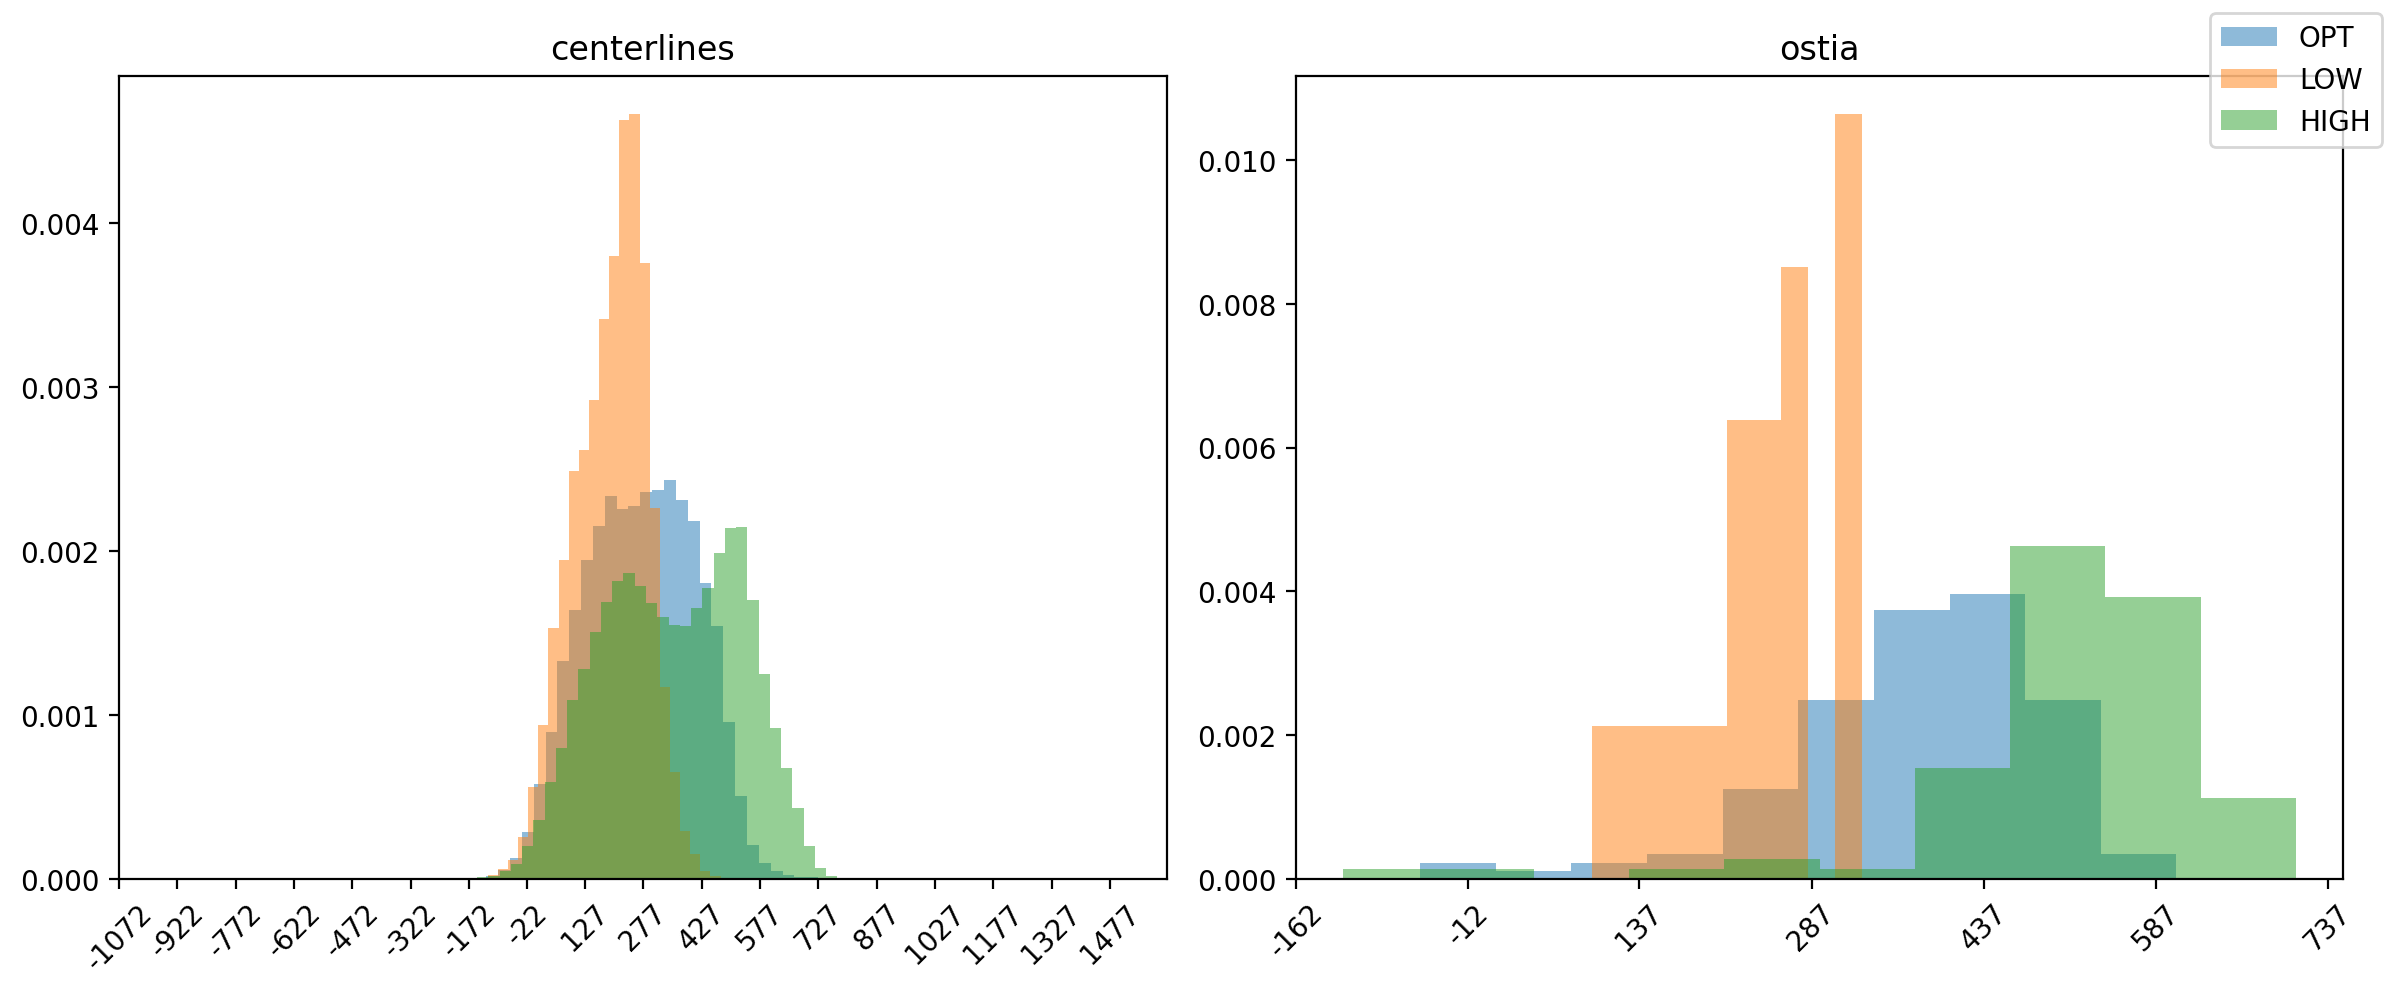

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# for ax in axes.flat:
#     ax.set_xlim(-200, 800)
#     ax.set_ylim(0, 0.0075)
#     ax[i, j].set_yticks([])

for tag, ax in zip(["centerlines", "ostia"], axes.flat):
    for st in ScanType:
        values = raw_HU_distributions[st][tag]
        _, bins, *_ = ax.hist(
            values,
            bins=80 if tag == "centerlines" else None,
            label=st.name,
            density=True,
            alpha=0.5,
        )
        print(
            tag,
            st,
            "median",
            np.median(values).astype(int),
            "mean",
            values.mean().astype(int),
            "bounds",
            values.min(),
            values.max(),
        )
    print()
    xticks = np.arange(*ax.get_xlim(), 150).astype(int)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks, rotation=45)
    ax.set_title(tag)

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)
fig.tight_layout()
plt.show()
plt.close(fig)